# Deep mutational scanning of ZIKV E protein NS5
Mutational antigenic profiling of ZIKV E from the MR766 strain.
Experiments performed by Blake Richardson and Matt Evans.
Analysis by [Jesse Bloom](https://research.fhcrc.org/bloom/en.html).

The NS5 mutagensis was performed in "tiles" along the length of the gene.
The generated virus was then grown +/- IFN.

## Set up for analysis
Import Python packages and modules:

In [1]:
import glob
import os
import shutil

import Bio.SeqIO

import dms_tools2
from dms_tools2 import AAS
from dms_tools2.ipython_utils import showPDF
from dms_tools2.plot import COLOR_BLIND_PALETTE_GRAY as CBPALETTE
import dms_tools2.prefs
print(f"Using dms_tools2 {dms_tools2.__version__}")

from IPython.display import display, HTML

import pandas as pd

Using dms_tools2 2.6.7


Specify configuration for analysis:

In [2]:
use_existing = 'yes' # use existing output

ncpus = 16  # max CPUs to use

# directories
resultsdir = './results/'
os.makedirs(resultsdir, exist_ok=True)

Input data found in the [./data/](data) directory:

In [3]:
refseqfile = './data/tile_1_amplicon.fasta'  # sequence of wildtype gene
samplelist = './data/samplelist.csv'  # samples sequenced
alignspecsfile = './data/subamplicon_alignspecs.txt'  # alignment specifications

Read in the wildtype (reference) sequence and its protein translation:

In [4]:
refseqrecord = Bio.SeqIO.read(refseqfile, 'fasta')
refprot = str(refseqrecord.seq.translate())
refseq = str(refseqrecord.seq)

print(f"Read wildtype (reference) sequence of {len(refseq)} nucleotides "
      f"that translates to protein of {len(refprot)} amino acids.")

Read wildtype (reference) sequence of 333 nucleotides that translates to protein of 111 amino acids.


## Process deep sequencing data
We process the data from the [barcoded subamplicon deep sequencing](https://jbloomlab.github.io/dms_tools2/bcsubamp.html) to count the frequency of each codon in each sample.

First, we read in the samples:

In [5]:
samples = (pd.read_csv(samplelist)
           .assign(name=lambda x: x.library + '-' + x.selection + '-' + x.date.astype(str))
           )

display(HTML(samples.to_html(index=False)))

Now we read in the alignment specs for the [barcoded subamplicon sequencing](https://jbloomlab.github.io/dms_tools2/bcsubamp.html):

In [6]:
with open(alignspecsfile) as f:
    alignspecs = f.read().strip()
print(alignspecs)

1,333,30,30


Now we use the [dms2_batch_bcsubamp](https://jbloomlab.github.io/dms_tools2/dms2_batch_bcsubamp.html) program to process the deep sequencing data to obtain codon counts:

In [7]:
countsdir = os.path.join(resultsdir, 'codoncounts')
os.makedirs(countsdir, exist_ok=True)

bcsubamp_batchfile = os.path.join(countsdir, 'batch.csv')
samples[['name', 'R1']].to_csv(bcsubamp_batchfile, index=False)

log = ! dms2_batch_bcsubamp \
        --batchfile {bcsubamp_batchfile} \
        --refseq {refseqfile} \
        --alignspecs {alignspecs} \
        --outdir {countsdir} \
        --summaryprefix summary \
        --R1trim 200 \
        --R2trim 200 \
        --ncpus {ncpus} \
        --use_existing {use_existing}

samples['codoncounts'] = countsdir + '/' + samples['name'] + '_codoncounts.csv'

# check that expected codon counts files created
assert all(map(os.path.isfile, samples.codoncounts)), '\n'.join(log)

print(f"Processed sequencing data to create codon counts files in {countsdir}")

Processed sequencing data to create codon counts files in ./results/codoncounts


Now we look at the plots.
They will all have the following prefix:

In [8]:
bcsubamp_plot_prefix = os.path.join(countsdir, 'summary_')

First, we look at the number of reads and barcodes per sample.
Most reads align with high quality, but many of the barcodes don't have too few reads.
This indicates we need more sequencing depth given the number of unique molecules (barcodes) that were retained going from round 1 to round 2 of the [barcoded subamplicon sequencing](https://jbloomlab.github.io/dms_tools2/bcsubamp.html).

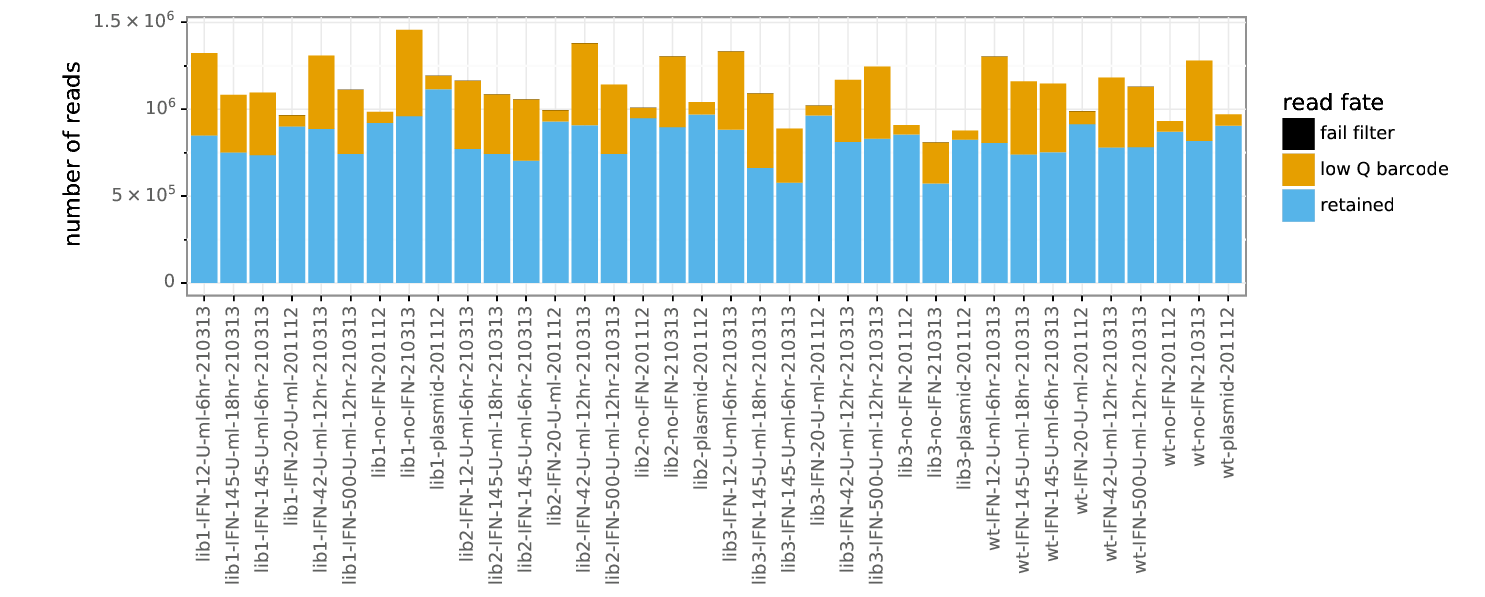

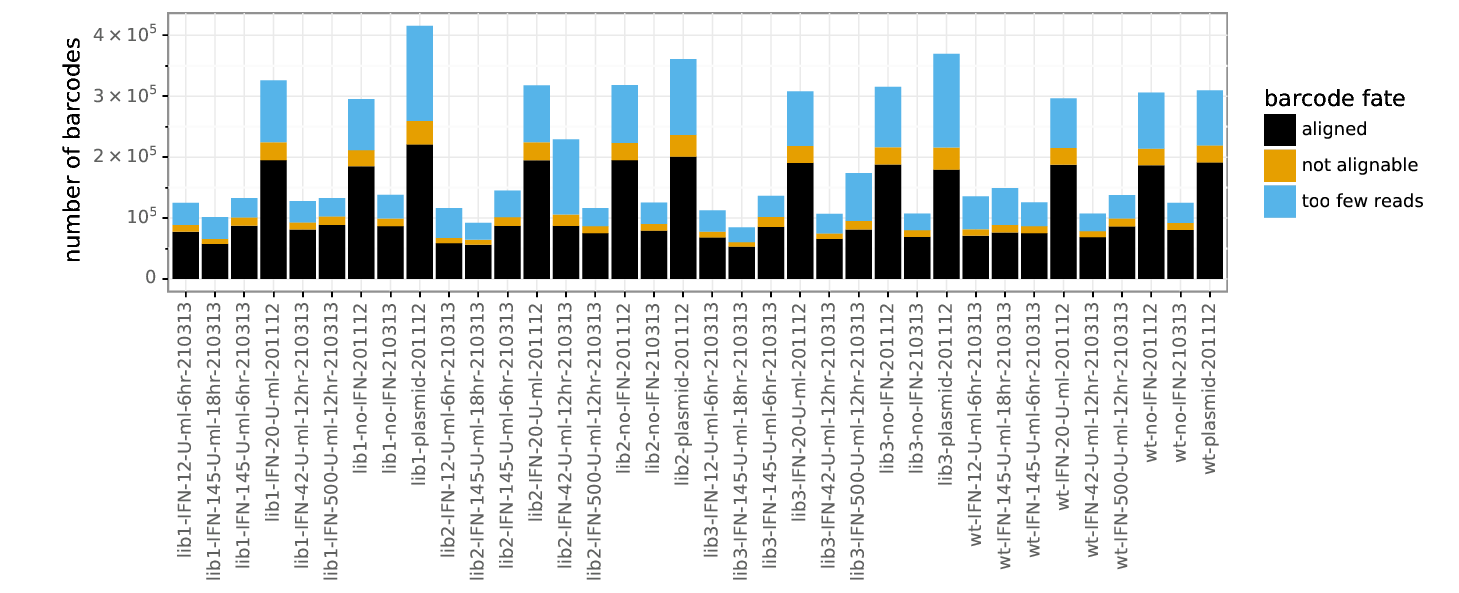

In [9]:
showPDF(bcsubamp_plot_prefix + 'readstats.pdf')
showPDF(bcsubamp_plot_prefix + 'bcstats.pdf')

Next we look at number of reads per barcode.
Again, this shows that we need more sequencing depth, as most barcodes only have a single read, which prevents error correction using multiple reads per barcode:

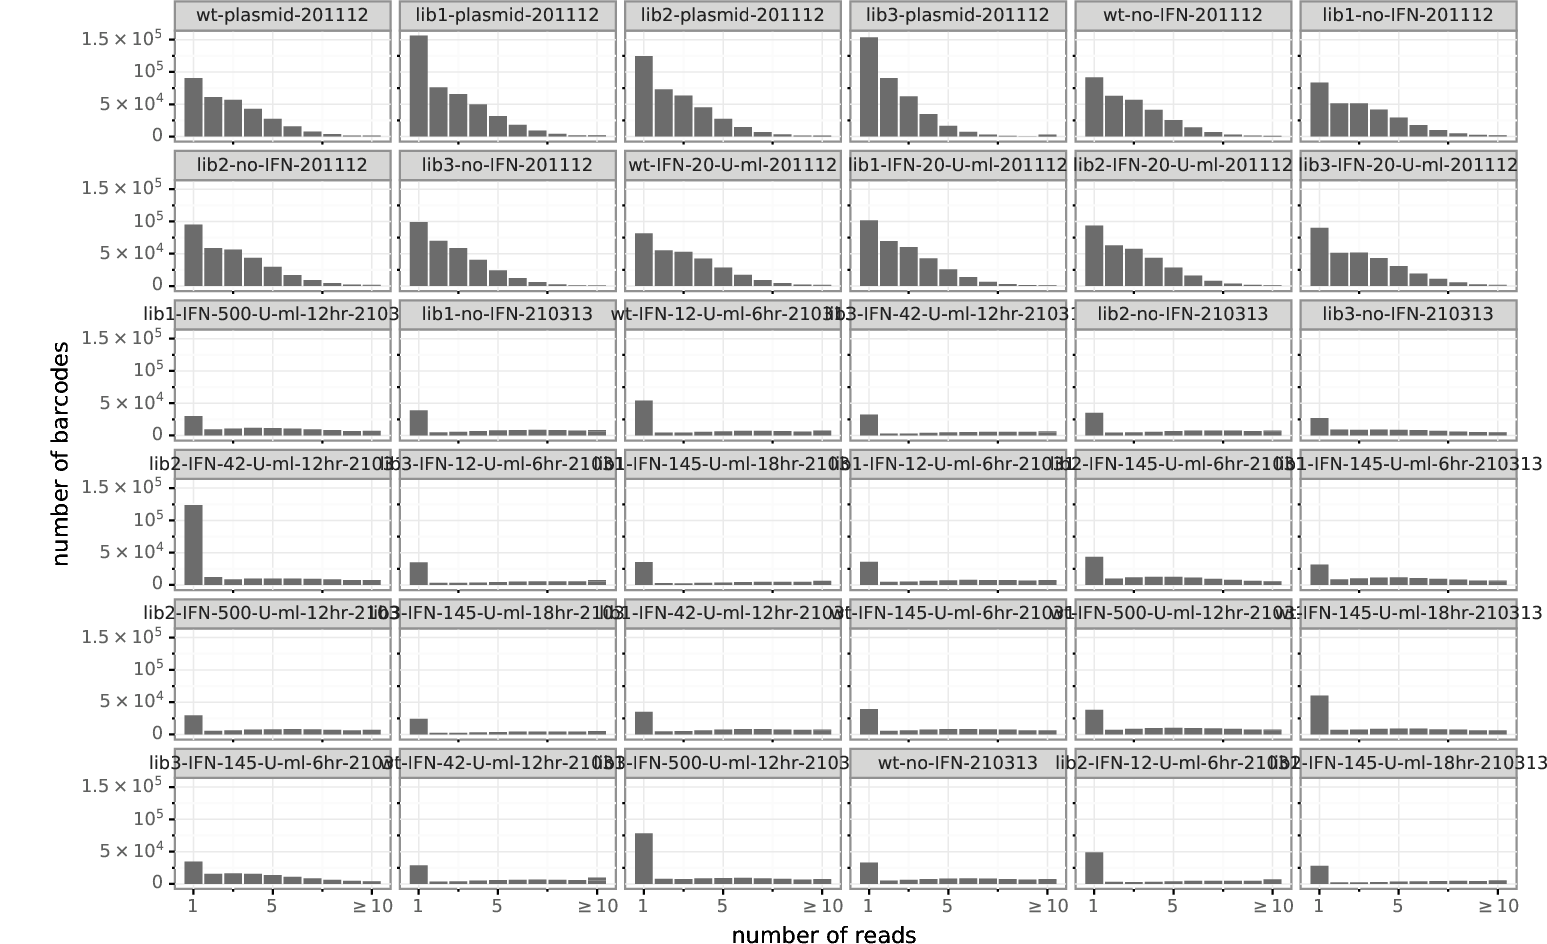

In [10]:
showPDF(bcsubamp_plot_prefix + 'readsperbc.pdf')

Now we look at the depth across the gene.
The depth is not uniform, suggesting that some subamplicons (particularly the second and third ones) were under-loaded relative to the other subamplicons:

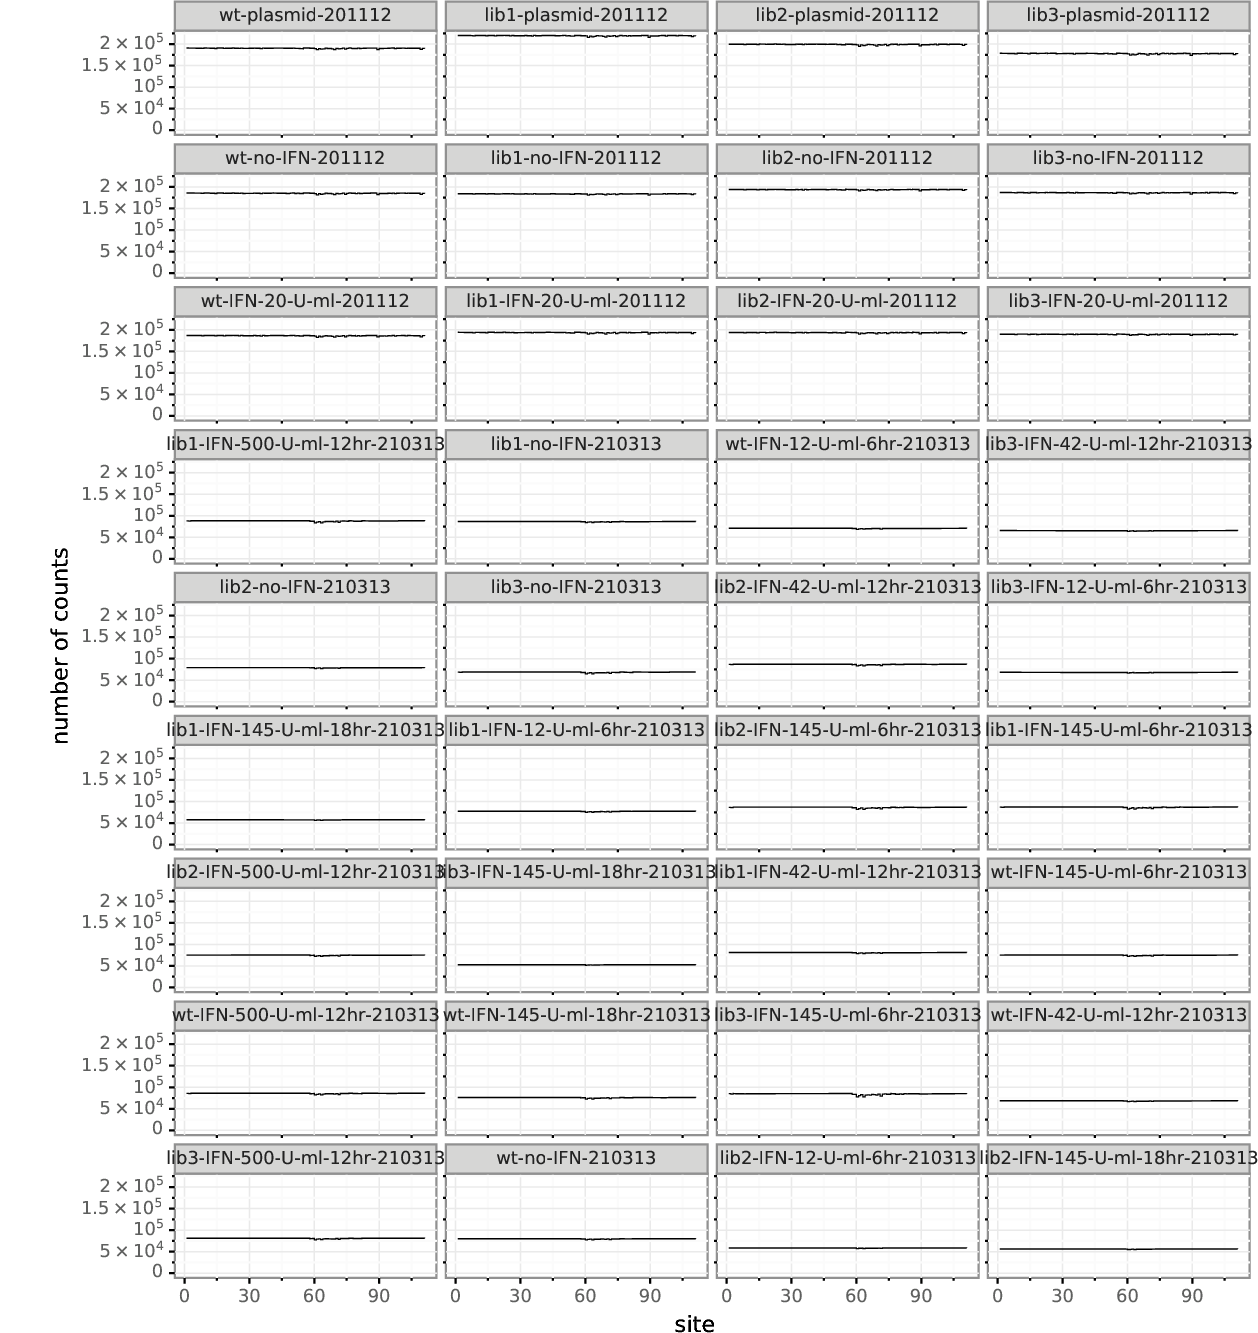

In [11]:
showPDF(bcsubamp_plot_prefix + 'depth.pdf')

Here are the mutation frequencies across the gene.
As expected, the library plasmids have higher mutation rates than the wildtype control:

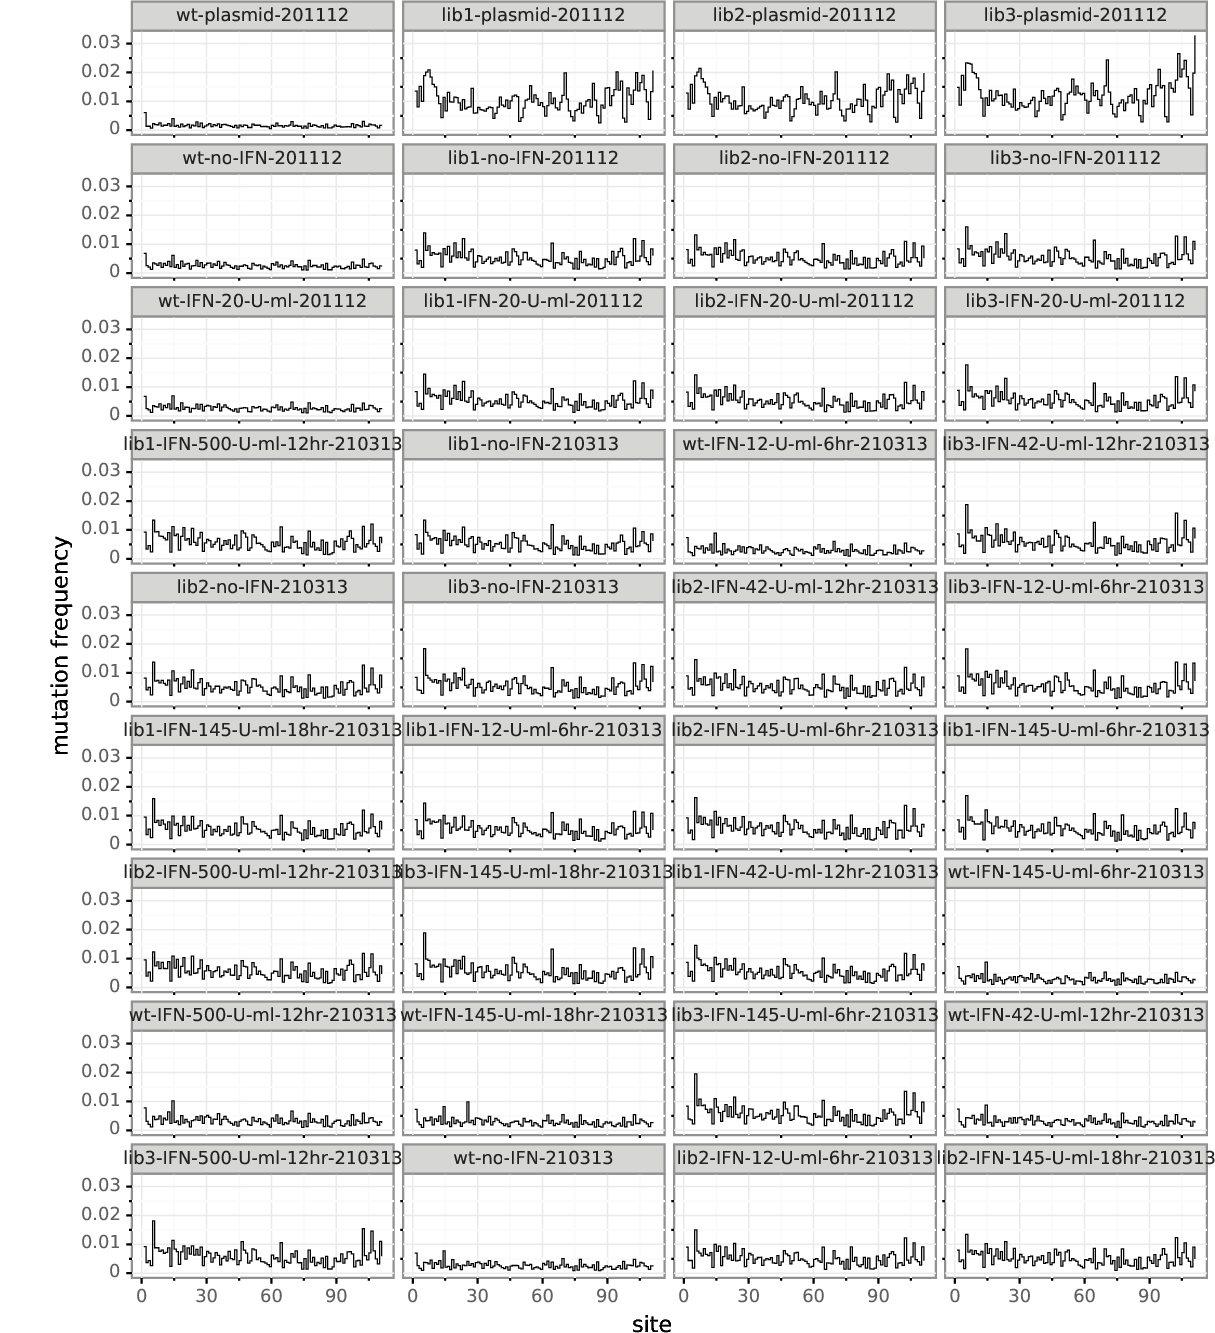

In [12]:
showPDF(bcsubamp_plot_prefix + 'mutfreq.pdf')

Here are the overall per-codon mutation rate averages:

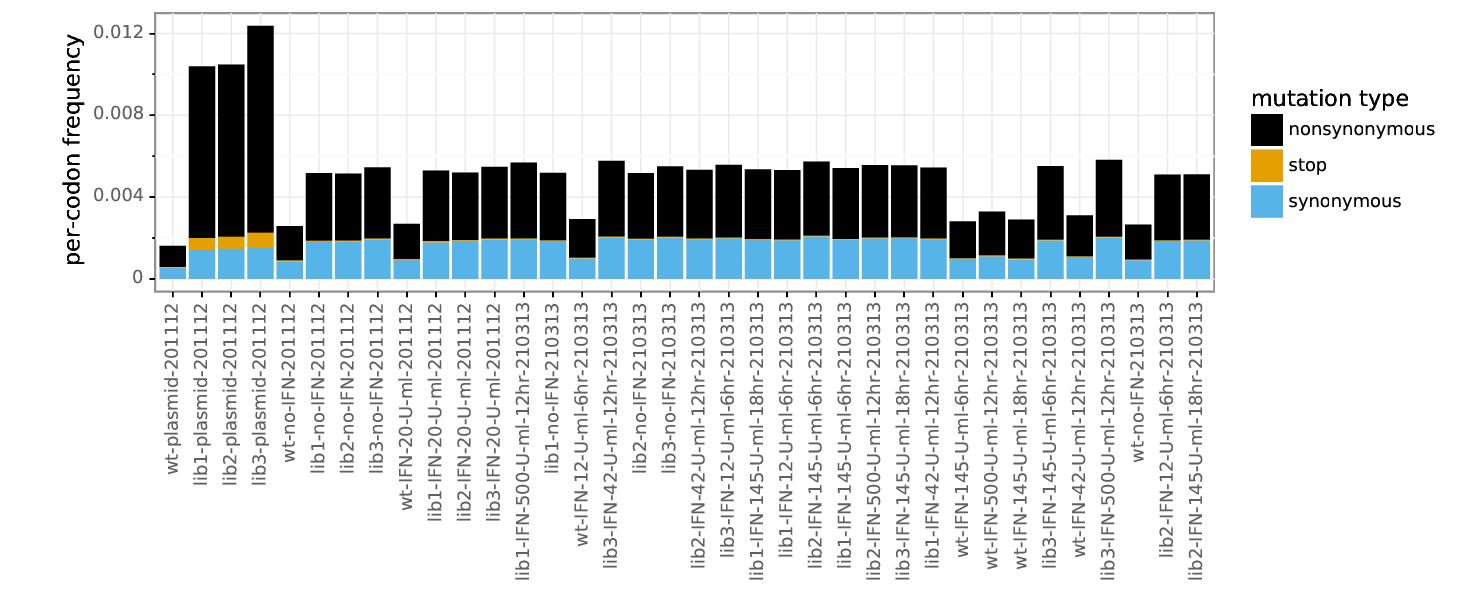

In [13]:
showPDF(bcsubamp_plot_prefix + 'codonmuttypes.pdf')

We have single and multi-nucleotide changes in the libraries, although the single nucleotide changes are perhaps over-represented:

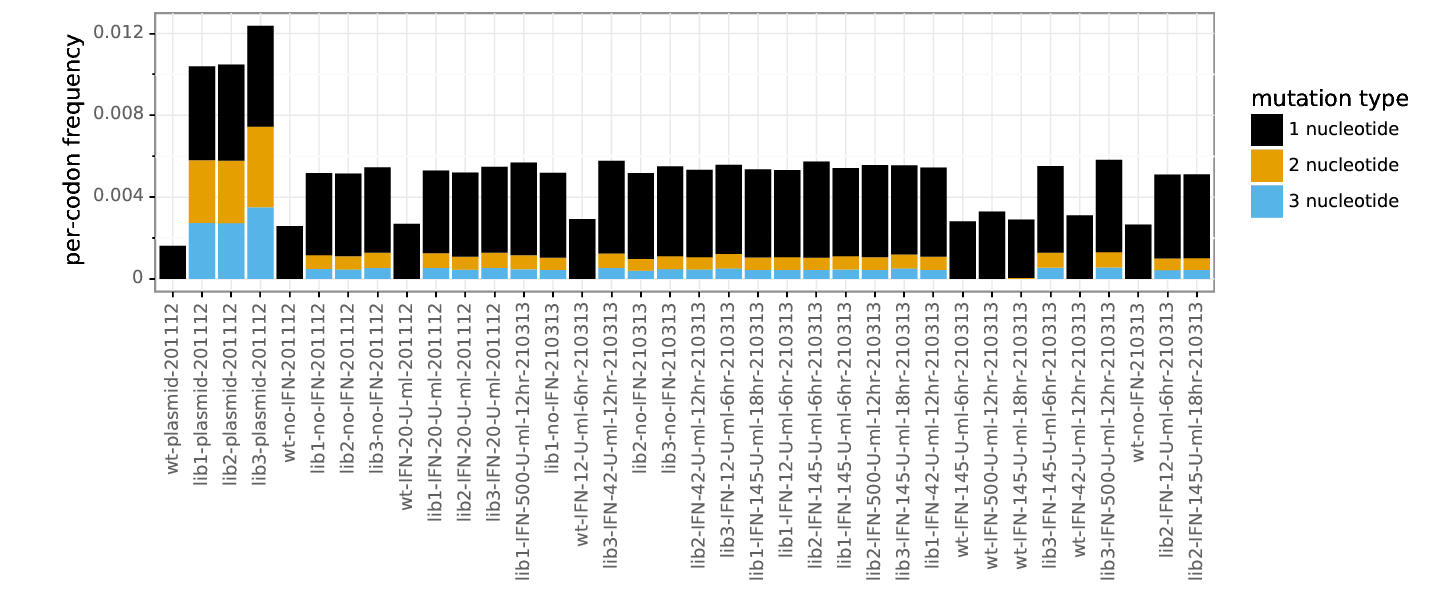

In [14]:
showPDF(bcsubamp_plot_prefix + 'codonntchanges.pdf')

Here are the frequencies of different types of mutations among single-nucleotide codon changes.
There is no massive over-representation of any class as would be expected if oxidative damage, which leads to `C->A` or `G->T` mutations:

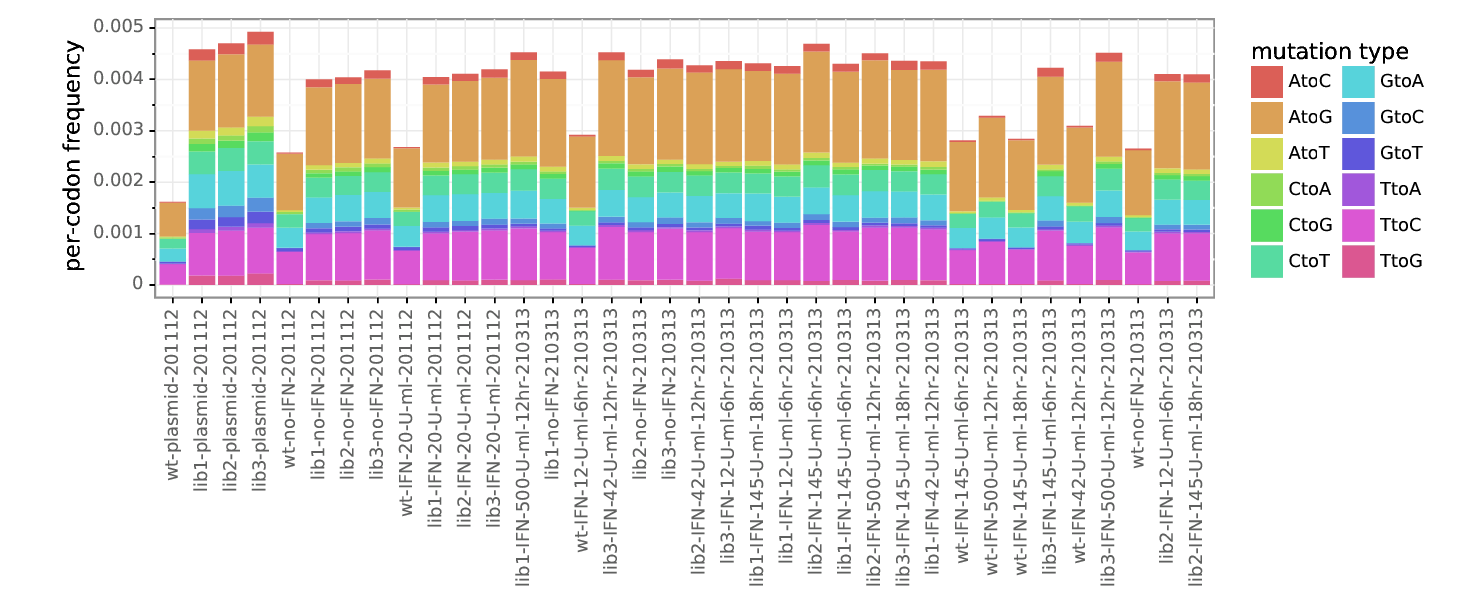

In [15]:
showPDF(bcsubamp_plot_prefix + 'singlentchanges.pdf')

Finally, we look at mutation sampling.
We can see that most possible mutations are sampled very well in the plasmid samples, although the overall coverage is still pretty low so some are missed:

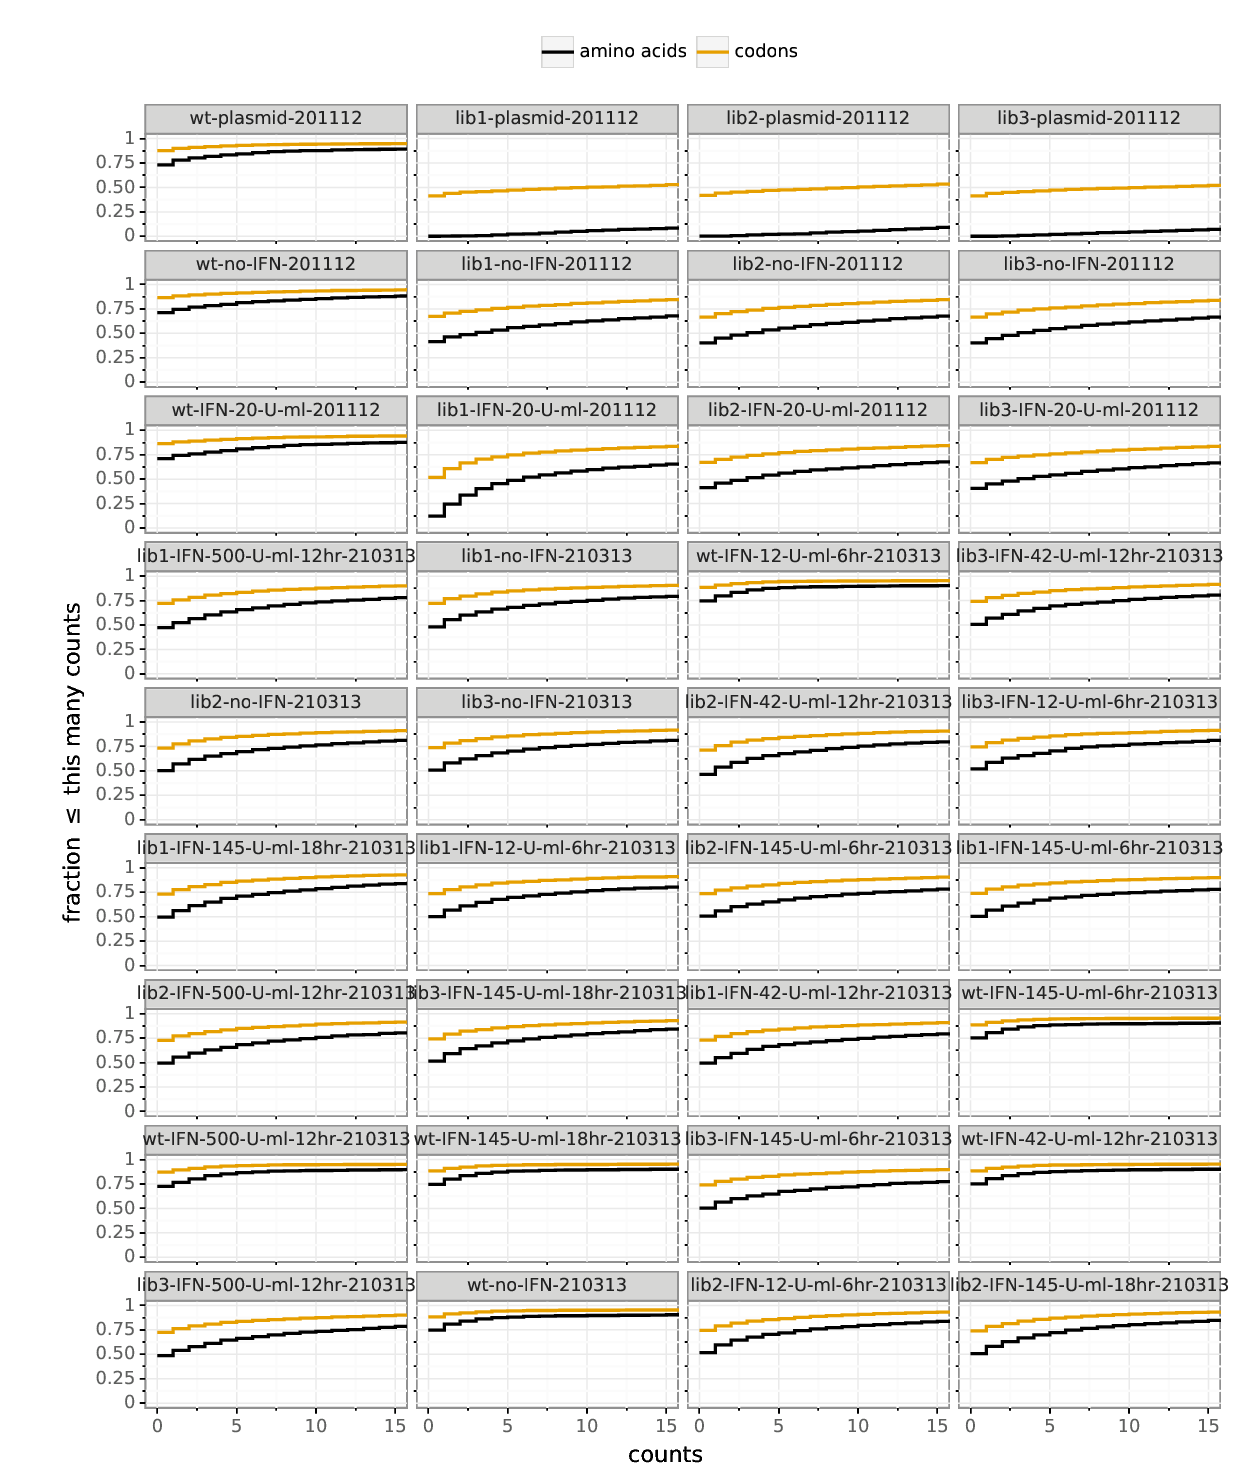

In [16]:
showPDF(bcsubamp_plot_prefix + 'cumulmutcounts.pdf')

## Functional effects of mutations of viral growth
Compute the functional effects of mutations on viral growth by comparing the passaged virus to the original plasmid, for both the +IFN and -IFN conditions.

To do this, we compute the [amino-acid preferences](https://jbloomlab.github.io/dms_tools2/prefs.html#prefs) under selection for viral growth.
We do this using [dms2_batch_prefs](https://jbloomlab.github.io/dms_tools2/dms2_batch_prefs.html).

First, make a data frame with the batch file:

In [17]:
prefs_batch = (
    samples
    .query('library != "wt"')
    .query('selection != "plasmid"')
    .assign(post=lambda x: x['name'])
    .merge(samples.query('selection == "plasmid"')
                  .assign(pre=lambda x: x['name'])
                  [['library', 'pre']],
           on=['library'], how='left', validate='many_to_one',
           )
    [['name', 'selection', 'library', 'pre', 'post', 'date']]
    .assign(errpre='wt-plasmid-201112')
    .merge(samples.query('library == "wt"')
                  .assign(errpost=lambda x: x['name'])
                  [['selection', 'errpost', 'date']],
           on=['selection', 'date'], how='left'
           )
    )
assert prefs_batch.notnull().all().all()

prefs_batch

name          selection library  \
0              lib1-no-IFN-201112             no-IFN    lib1   
1              lib2-no-IFN-201112             no-IFN    lib2   
2              lib3-no-IFN-201112             no-IFN    lib3   
3         lib1-IFN-20-U-ml-201112        IFN-20-U-ml    lib1   
4         lib2-IFN-20-U-ml-201112        IFN-20-U-ml    lib2   
5         lib3-IFN-20-U-ml-201112        IFN-20-U-ml    lib3   
6   lib1-IFN-500-U-ml-12hr-210313  IFN-500-U-ml-12hr    lib1   
7              lib1-no-IFN-210313             no-IFN    lib1   
8    lib3-IFN-42-U-ml-12hr-210313   IFN-42-U-ml-12hr    lib3   
9              lib2-no-IFN-210313             no-IFN    lib2   
10             lib3-no-IFN-210313             no-IFN    lib3   
11   lib2-IFN-42-U-ml-12hr-210313   IFN-42-U-ml-12hr    lib2   
12    lib3-IFN-12-U-ml-6hr-210313    IFN-12-U-ml-6hr    lib3   
13  lib1-IFN-145-U-ml-18hr-210313  IFN-145-U-ml-18hr    lib1   
14    lib1-IFN-12-U-ml-6hr-210313    IFN-12-U-ml-6hr    lib1   
15   lib2-IFN-145-U-ml-6hr-210313   IFN-145-U-ml-6hr    lib2   
16   lib1-IFN-145-U-ml-6hr-210313   IFN-145-U-ml-6hr    lib1   
17  lib2-IFN-500-U-ml-12hr-210313  IFN-500-U-ml-12hr    lib2   
18  lib3-IFN-145-U-ml-18hr-210313  IFN-145-U-ml-18hr    lib3   
19   lib1-IFN-42-U-ml-12hr-210313   IFN-42-U-ml-12hr    lib1   
20   lib3-IFN-145-U-ml-6hr-210313   IFN-145-U-ml-6hr    lib3   
21  lib3-IFN-500-U-ml-12hr-210313  IFN-500-U-ml-12hr    lib3   
22    lib2-IFN-12-U-ml-6hr-210313    IFN-12-U-ml-6hr    lib2   
23  lib2-IFN-145-U-ml-18hr-210313  IFN-145-U-ml-18hr    lib2   

                    pre                           post    date  \
0   lib1-plasmid-201112             lib1-no-IFN-201112  201112   
1   lib2-plasmid-201112             lib2-no-IFN-201112  201112   
2   lib3-plasmid-201112             lib3-no-IFN-201112  201112   
3   lib1-plasmid-201112        lib1-IFN-20-U-ml-201112  201112   
4   lib2-plasmid-201112        lib2-IFN-20-U-ml-201112  201112   
5   lib3-plasmid-201112        lib3-IFN-20-U-ml-201112  201112   
6   lib1-plasmid-201112  lib1-IFN-500-U-ml-12hr-210313  210313   
7   lib1-plasmid-201112             lib1-no-IFN-210313  210313   
8   lib3-plasmid-201112   lib3-IFN-42-U-ml-12hr-210313  210313   
9   lib2-plasmid-201112             lib2-no-IFN-210313  210313   
10  lib3-plasmid-201112             lib3-no-IFN-210313  210313   
11  lib2-plasmid-201112   lib2-IFN-42-U-ml-12hr-210313  210313   
12  lib3-plasmid-201112    lib3-IFN-12-U-ml-6hr-210313  210313   
13  lib1-plasmid-201112  lib1-IFN-145-U-ml-18hr-210313  210313   
14  lib1-plasmid-201112    lib1-IFN-12-U-ml-6hr-210313  210313   
15  lib2-plasmid-201112   lib2-IFN-145-U-ml-6hr-210313  210313   
16  lib1-plasmid-201112   lib1-IFN-145-U-ml-6hr-210313  210313   
17  lib2-plasmid-201112  lib2-IFN-500-U-ml-12hr-210313  210313   
18  lib3-plasmid-201112  lib3-IFN-145-U-ml-18hr-210313  210313   
19  lib1-plasmid-201112   lib1-IFN-42-U-ml-12hr-210313  210313   
20  lib3-plasmid-201112   lib3-IFN-145-U-ml-6hr-210313  210313   
21  lib3-plasmid-201112  lib3-IFN-500-U-ml-12hr-210313  210313   
22  lib2-plasmid-201112    lib2-IFN-12-U-ml-6hr-210313  210313   
23  lib2-plasmid-201112  lib2-IFN-145-U-ml-18hr-210313  210313   

               errpre                      errpost  
0   wt-plasmid-201112             wt-no-IFN-201112  
1   wt-plasmid-201112             wt-no-IFN-201112  
2   wt-plasmid-201112             wt-no-IFN-201112  
3   wt-plasmid-201112        wt-IFN-20-U-ml-201112  
4   wt-plasmid-201112        wt-IFN-20-U-ml-201112  
5   wt-plasmid-201112        wt-IFN-20-U-ml-201112  
6   wt-plasmid-201112  wt-IFN-500-U-ml-12hr-210313  
7   wt-plasmid-201112             wt-no-IFN-210313  
8   wt-plasmid-201112   wt-IFN-42-U-ml-12hr-210313  
9   wt-plasmid-201112             wt-no-IFN-210313  
10  wt-plasmid-201112             wt-no-IFN-210313  
11  wt-plasmid-201112   wt-IFN-42-U-ml-12hr-210313  
12  wt-plasmid-201112    wt-IFN-12-U-ml-6hr-210313  
13  wt-plasmid-201112  wt-IFN-145-U

Now run [dms2_batch_prefs](https://jbloomlab.github.io/dms_tools2/dms2_batch_prefs.html):

In [18]:
prefsdir = os.path.join(resultsdir, 'prefs')
os.makedirs(prefsdir, exist_ok=True)

prefs_batchfile = os.path.join(prefsdir, 'batch.csv')
prefs_batch.to_csv(prefs_batchfile, index=False)

log = ! dms2_batch_prefs \
        --indir {countsdir} \
        --batchfile {prefs_batchfile} \
        --outdir {prefsdir} \
        --summaryprefix summary \
        --use_existing {use_existing} \
        --ncpus {ncpus}

assert all(map(os.path.isfile, [os.path.join(prefsdir, name + '_prefs.csv') 
                                for name in prefs_batch.name])), '\n'.join(log)

print("Amino-acid preferences calculated for all samples.")

Amino-acid preferences calculated for all samples.


Look at correlation among the amino-acid preferences for the individual libraries:

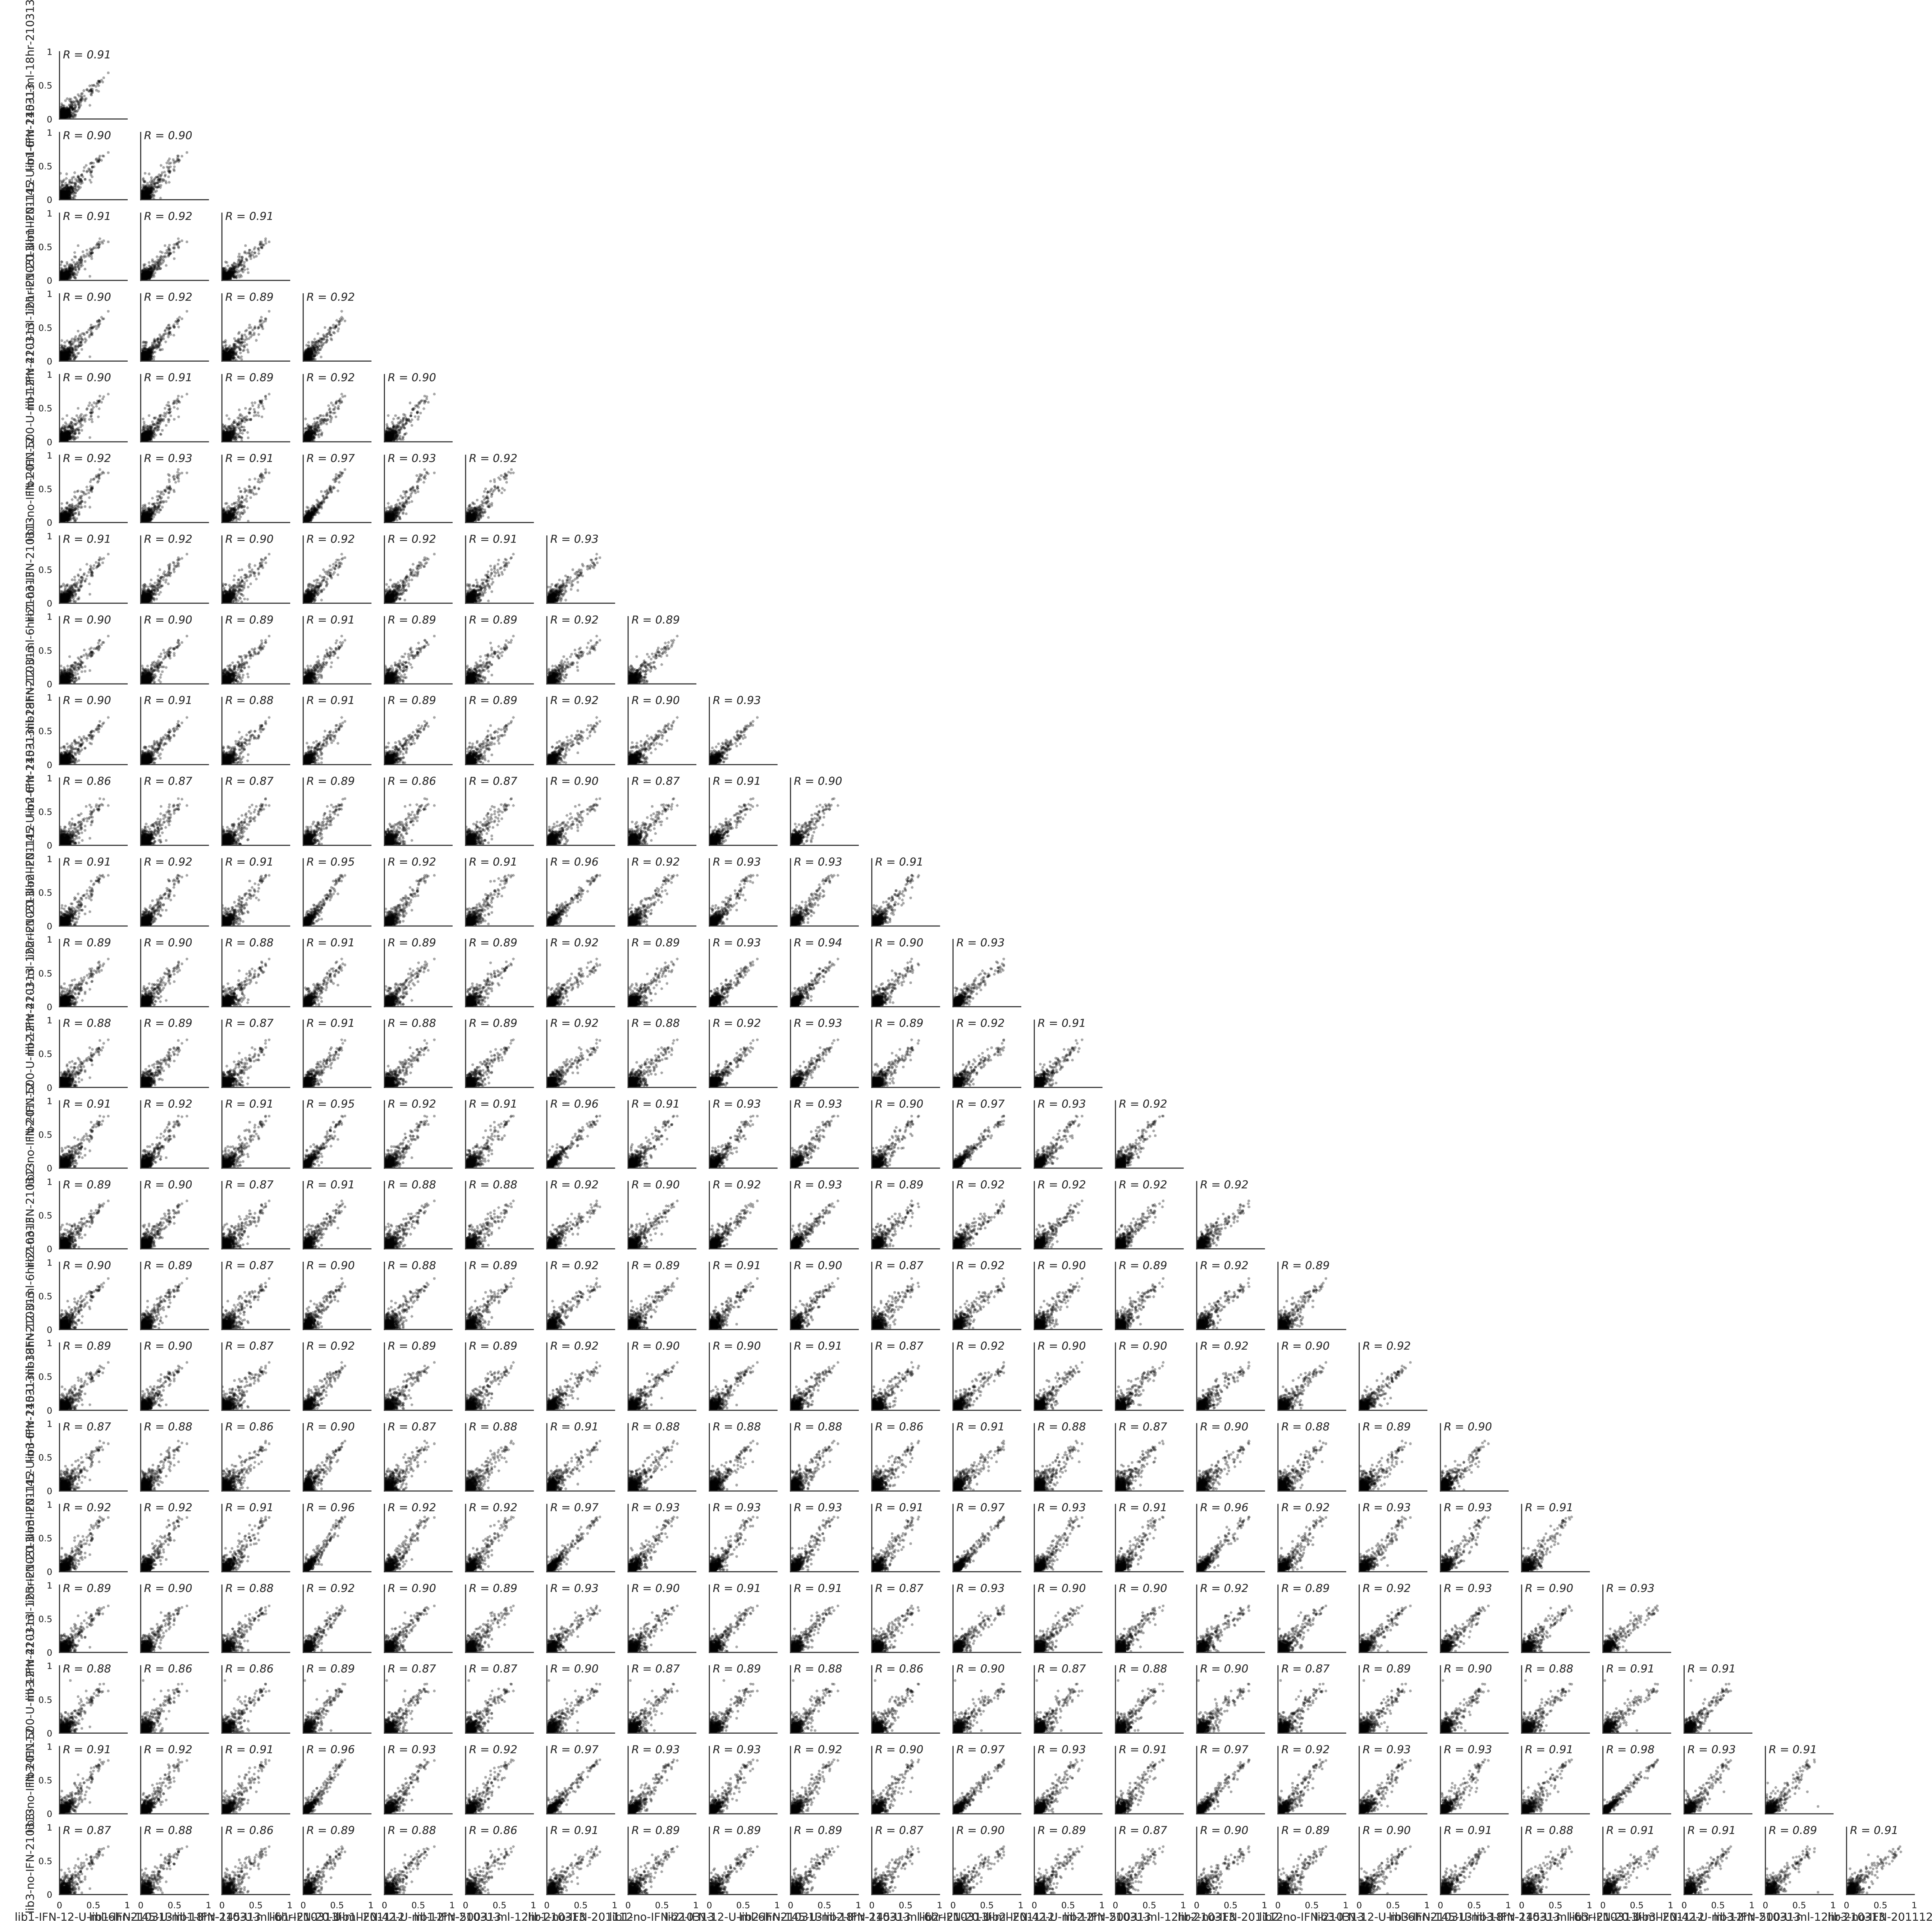

In [19]:
showPDF(os.path.join(prefsdir, 'summary_prefscorr.pdf'))

Now let's get the amino-acid preferences for **all** samples (with and without IFN), and for the IFN+ and IFN- ones separately:

In [20]:
# file with preferences for all samples
prefs_files = {'all': os.path.join(prefsdir, 'prefs_all.csv')}
pd.read_csv(os.path.join(prefsdir, 'summary_avgprefs.csv')).to_csv(prefs_files['all'],
                                                                   index=False,
                                                                   float_format='%.5f')

# file with preferences for each condition
for selection, df in prefs_batch.groupby('selection'):
    selection_prefsfiles = [os.path.join(prefsdir, f"{name}_prefs.csv") for name in df['name']]
    assert all(map(os.path.isfile, selection_prefsfiles)), selection_prefsfiles
    prefs_files[selection] = os.path.join(prefsdir, f"prefs_{selection}.csv")
    dms_tools2.prefs.avgPrefs(selection_prefsfiles).to_csv(prefs_files[selection],
                                                           index=False,
                                                           float_format='%.5f')
    
print('Average preferences across conditions are in the following files:')
display(HTML(pd.Series(prefs_files).rename('file').to_frame().to_html()))

Average preferences across conditions are in the following files:


Now we will make a logo plot of the average of the amino-acid preferences across all samples, for IFN+ samples, and for IFN- samples.
We do this using [dms2_logoplot](https://jbloomlab.github.io/dms_tools2/dms2_logoplot.html).
Note that this logo plot shows the raw unscaled (not re-scaled) preferences.
In this plot, the height of each letter is proportional to the "preference" for that amino acid at that site, so taller letters are more preferred at a site.
If the site tolerates everything, there will just be lots of small letters as all amino acids equally tolerated:



Preferences for all samples:


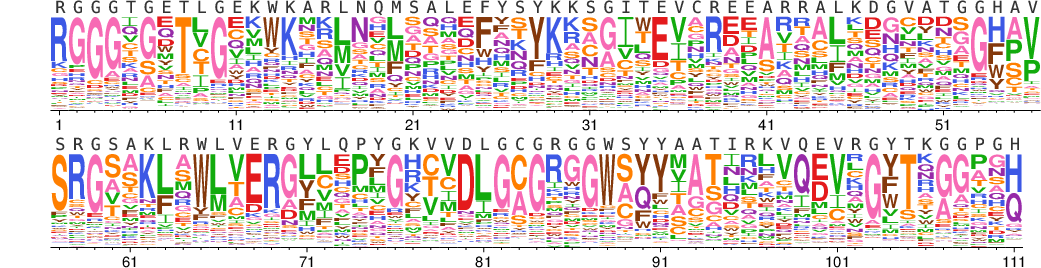



Preferences for IFN-12-U-ml-6hr samples:


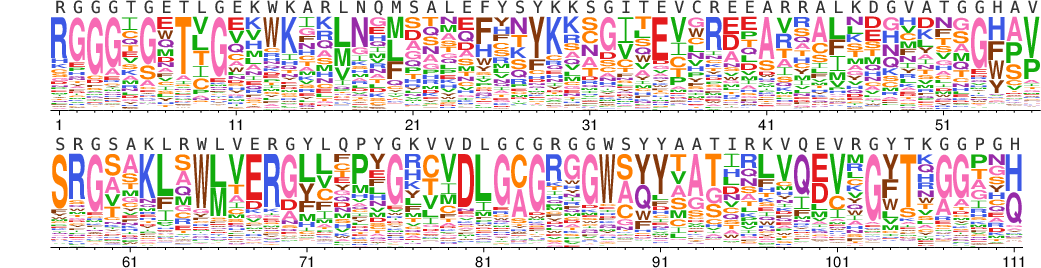



Preferences for IFN-145-U-ml-18hr samples:


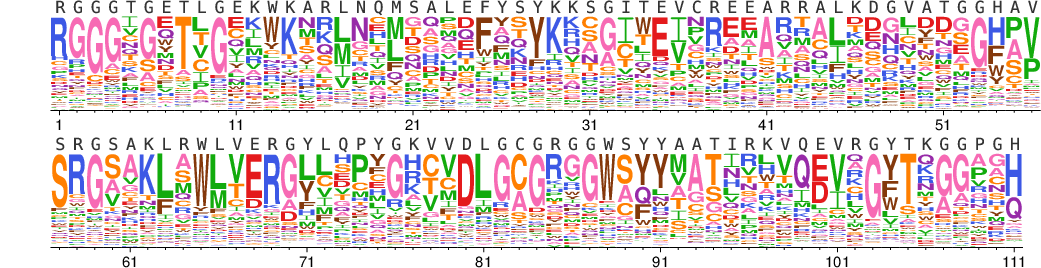



Preferences for IFN-145-U-ml-6hr samples:


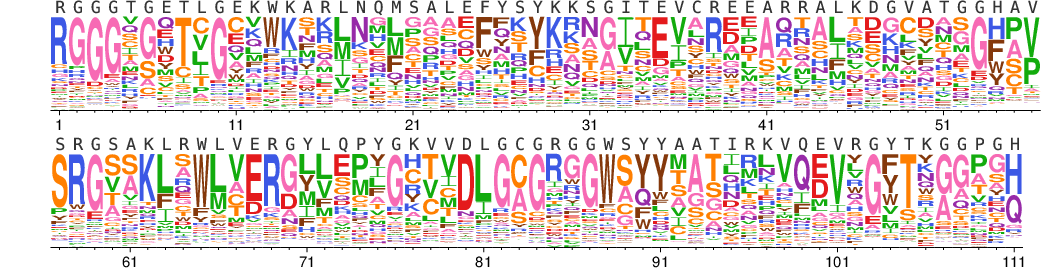



Preferences for IFN-20-U-ml samples:


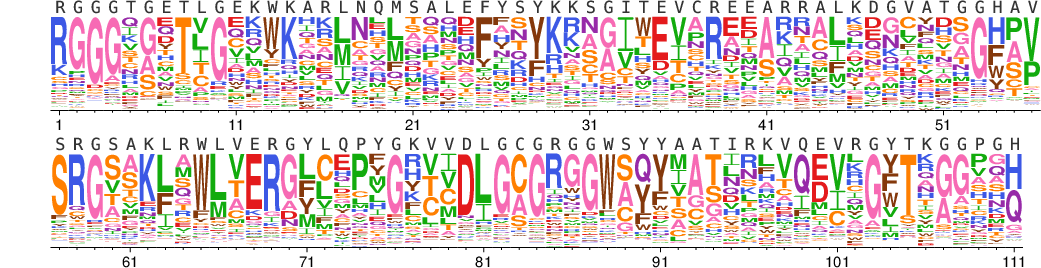



Preferences for IFN-42-U-ml-12hr samples:


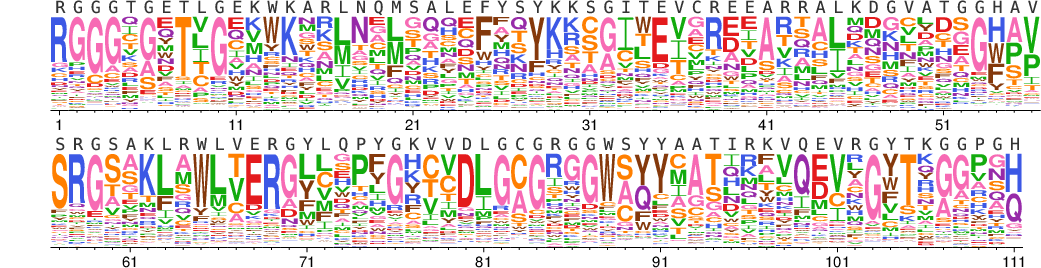



Preferences for IFN-500-U-ml-12hr samples:


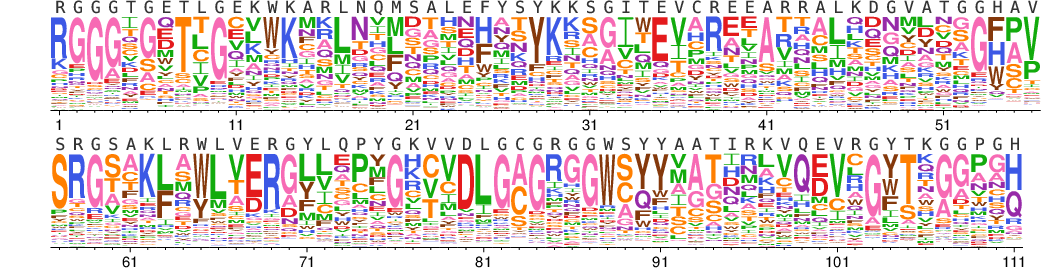



Preferences for no-IFN samples:


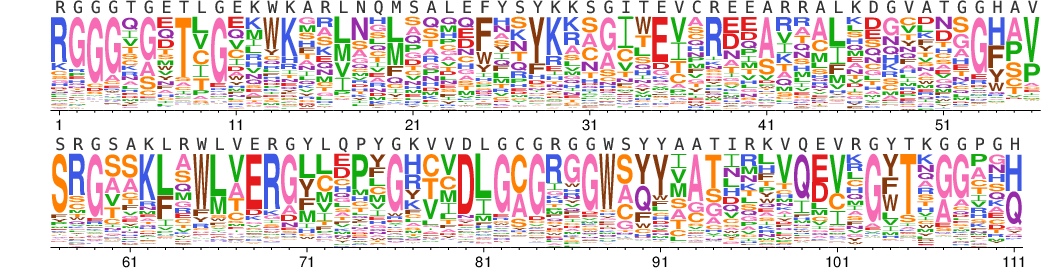

In [21]:
logodir = os.path.join(resultsdir, 'logoplots')
os.makedirs(logodir, exist_ok=True)

# get wildtype amino acids to use as overlay
wt_aas = pd.DataFrame.from_records(
            [(r + 1, a) for r, a in enumerate(refprot)],
            columns=['site', 'wildtype'])
wtoverlayfile = os.path.join(logodir, 'wt_overlay.csv')
wt_aas.to_csv(wtoverlayfile, index=False)

for selection, prefs_csv in prefs_files.items():

    logoplot = os.path.join(logodir, f"{selection}_prefs.pdf")

    log = ! dms2_logoplot \
            --prefs {prefs_csv} \
            --name {selection} \
            --outdir {logodir} \
            --nperline 56 \
            --overlay1 {wtoverlayfile} wildtype wildtype \
            --letterheight 1.2 \
            --use_existing {use_existing}

    assert os.path.isfile(logoplot), '\n'.join(log)

    print(f"\n\nPreferences for {selection} samples:")
    showPDF(logoplot)

We can also represent the effects of mutations in a different way than the amino acid preferences.
Specifically, the ratio of the preference for the mutant amino-acid to the wildtype amino-acid is a measure of its enrichment (this is just the ratio of letter heights in the plot above).
If we take the log of this mutational effect, negative values indicate deleterious mutations and positive values indicate favorable mutations
The potential advantage of this representation is that it better shows the detailed differences between mutations to amino acids with small preferences, which can be useful for figuring out if we think a mutation is just very mildly deleterious or highly deleterious.

Here we calculate the mutational effects and then plot their log2 values on a logo plot.

First, create a subdirectory for these analyses:

In [22]:
muteffectsdir = os.path.join(resultsdir, 'muteffects/')
os.makedirs(muteffectsdir, exist_ok=True)

Convert the amino-acid preferences into mutational effects:

In [23]:
muteffects_files = {}
for selection, prefs_csv in prefs_files.items():
    muteffects = dms_tools2.prefs.prefsToMutFromWtEffects(
                    prefs=pd.read_csv(prefs_csv),
                    charlist=AAS,
                    wts=wt_aas)
    muteffects_files[selection] = os.path.join(muteffectsdir, f"{selection}_muteffects.csv")
    print(f"Writing mutational effects for {selection} to {muteffects_files[selection]}")
    muteffects.to_csv(muteffects_files[selection], index=False, float_format='%.5g')

Writing mutational effects for all to ./results/muteffects/all_muteffects.csv
Writing mutational effects for IFN-12-U-ml-6hr to ./results/muteffects/IFN-12-U-ml-6hr_muteffects.csv
Writing mutational effects for IFN-145-U-ml-18hr to ./results/muteffects/IFN-145-U-ml-18hr_muteffects.csv
Writing mutational effects for IFN-145-U-ml-6hr to ./results/muteffects/IFN-145-U-ml-6hr_muteffects.csv
Writing mutational effects for IFN-20-U-ml to ./results/muteffects/IFN-20-U-ml_muteffects.csv
Writing mutational effects for IFN-42-U-ml-12hr to ./results/muteffects/IFN-42-U-ml-12hr_muteffects.csv
Writing mutational effects for IFN-500-U-ml-12hr to ./results/muteffects/IFN-500-U-ml-12hr_muteffects.csv
Writing mutational effects for no-IFN to ./results/muteffects/no-IFN_muteffects.csv


Now make a logo plots showing the mutational effects for all samples, the IFN+ ones, and the IFN- ones.
Letters below the line indicate deleterious mutations, and letters above the line indicate beneficial ones.
We include a scale bar indicating the fold-enrichment implied by each letter height:



Mutational effects for all samples:


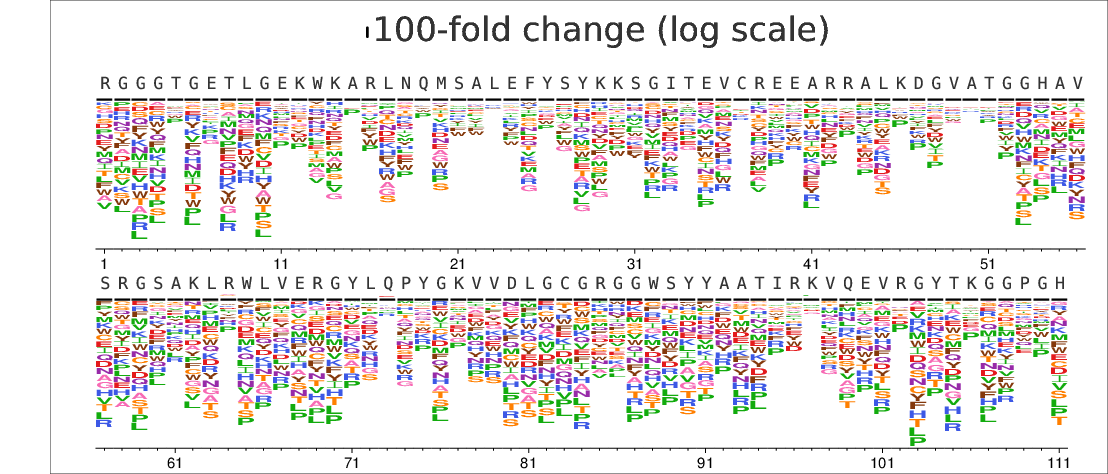



Mutational effects for IFN-12-U-ml-6hr samples:


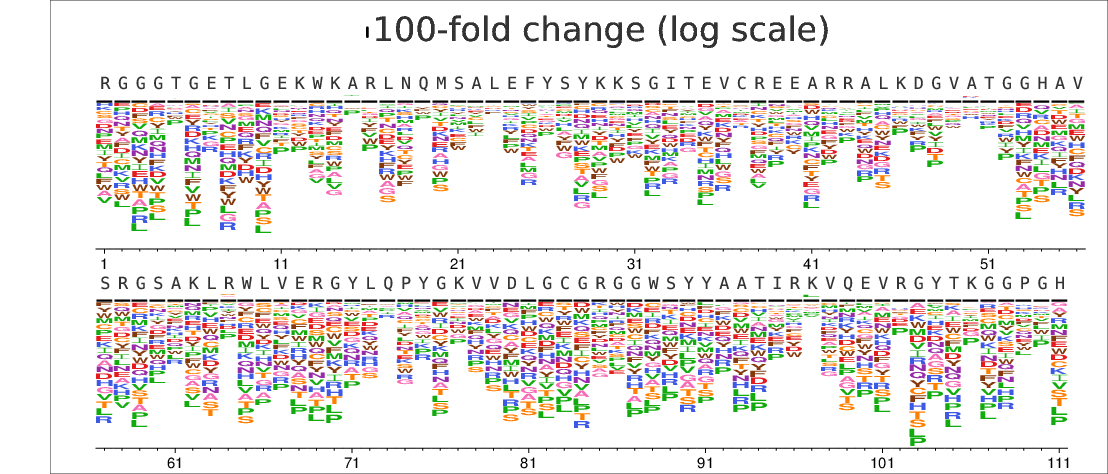



Mutational effects for IFN-145-U-ml-18hr samples:


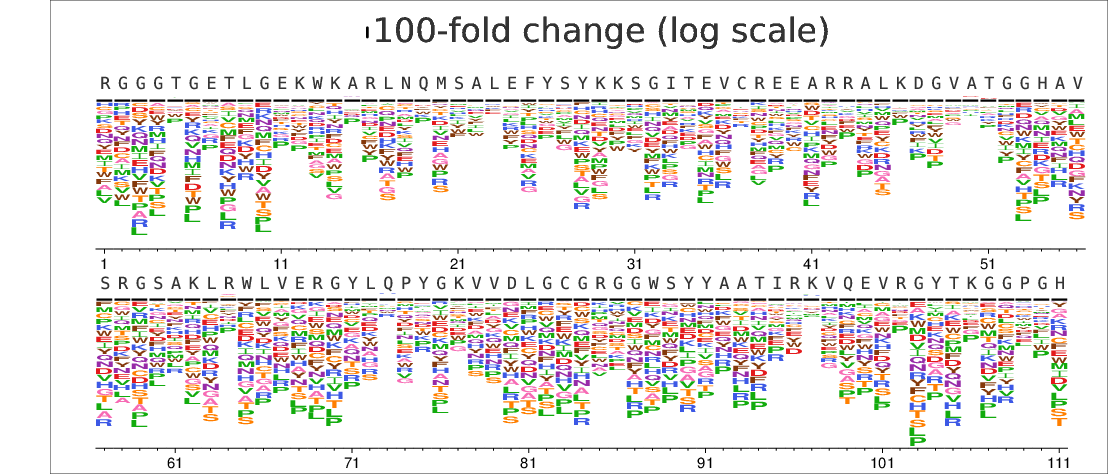



Mutational effects for IFN-145-U-ml-6hr samples:


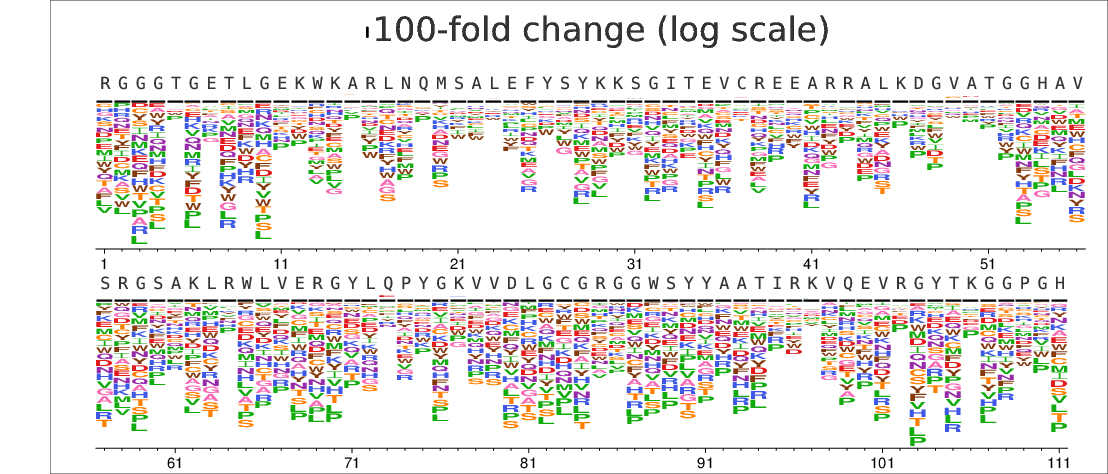



Mutational effects for IFN-20-U-ml samples:


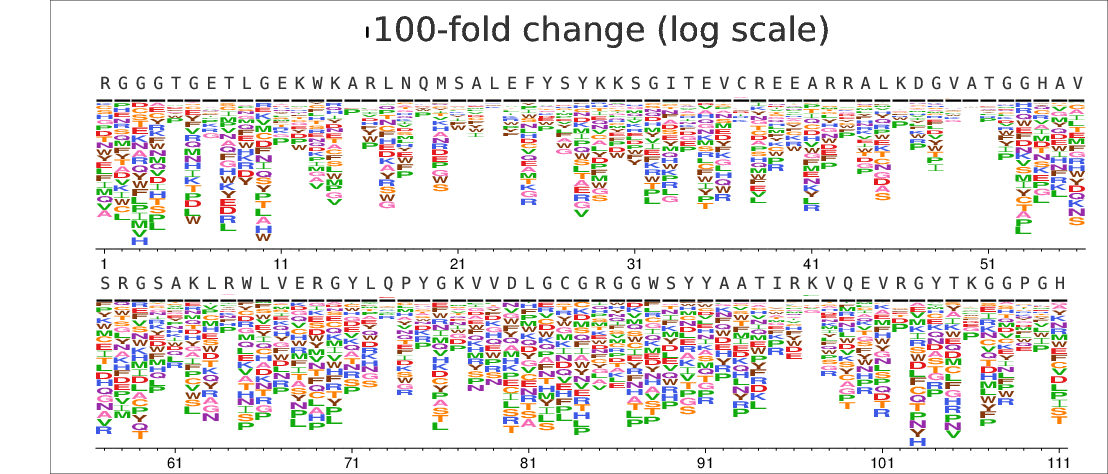



Mutational effects for IFN-42-U-ml-12hr samples:


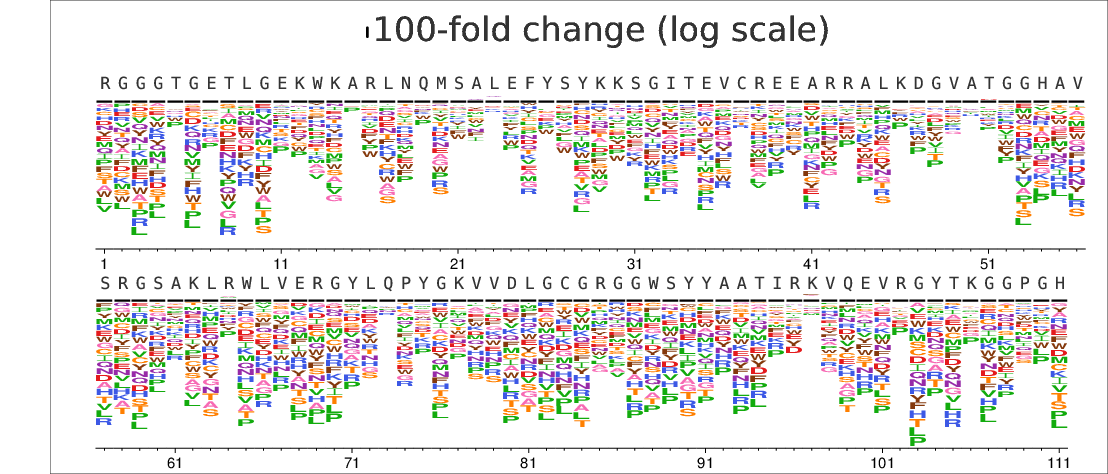



Mutational effects for IFN-500-U-ml-12hr samples:


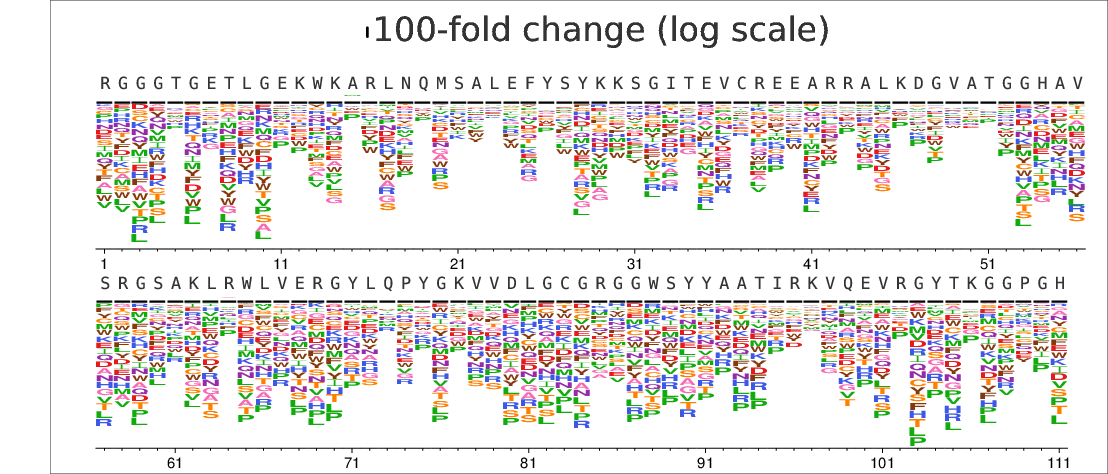



Mutational effects for no-IFN samples:


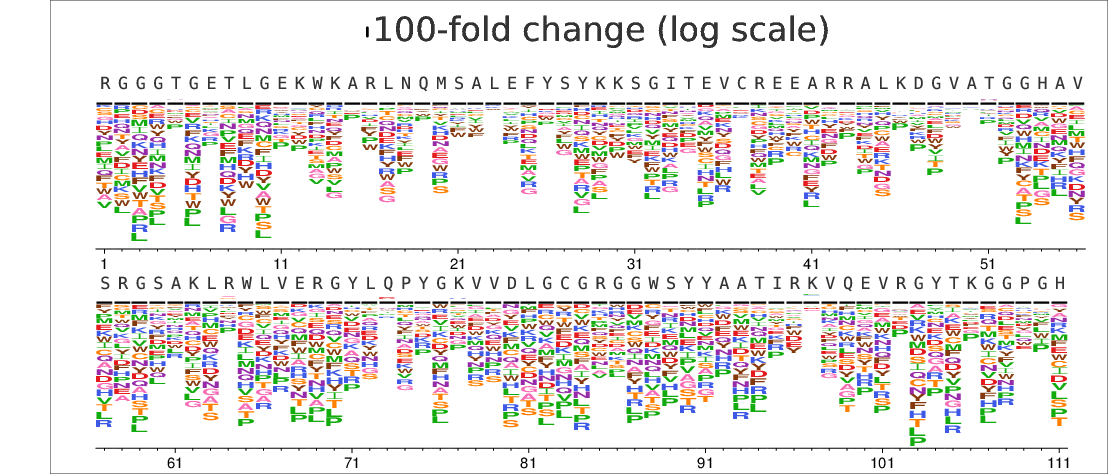

In [24]:
for selection, muteffects_csv in muteffects_files.items():

    logoplot = os.path.join(logodir, f"{selection}_muteffects.pdf")

    log = ! dms2_logoplot \
            --muteffects {muteffects_csv} \
            --name {selection} \
            --outdir {logodir} \
            --nperline 56 \
            --overlay1 {wtoverlayfile} wildtype wildtype \
            --scalebar 6.64 "100-fold change (log scale)" \
            --use_existing {use_existing}

    assert os.path.isfile(logoplot), '\n'.join(log)

    print(f"\n\nMutational effects for {selection} samples:")
    showPDF(logoplot)

## Differential selection between IFN+ and IFN- conditions
We now compute the [differential selection](https://jbloomlab.github.io/dms_tools2/diffsel.html) from each antibody selection.
We do this using [dms2_batch_diffsel](https://jbloomlab.github.io/dms_tools2/dms2_batch_diffsel.html).

In [25]:
diffseldir = os.path.join(resultsdir, 'diffsel')
os.makedirs(diffseldir, exist_ok=True)

Now we create a batch file for running [dms2_batch_diffsel](https://jbloomlab.github.io/dms_tools2/dms2_batch_diffsel.html).
Note that we use the IFN- condition as our mock selection and the wildtype virus with no IFN as the error control:

In [26]:
diffsel_batch = (
    samples
    .assign(sel=lambda x: x['name'],
            mock=lambda x: x['library'] + '-no-IFN' + '-' + x['date'].astype(str),
            err=lambda x: 'wt-no-IFN-' + x['date'].astype(str),
            )
    .query('selection not in ["plasmid", "no-IFN"]')
    .query('library != "wt"')
    .drop(columns=['name'])
    .rename(columns={'selection':'group', 'library':'name'})
    [['group', 'name', 'sel', 'mock', 'err']]
    .reset_index(drop=True)
    )

display(HTML(diffsel_batch.to_html(index=False)))

Write the batch file and run [dms2_batch_diffsel](https://jbloomlab.github.io/dms_tools2/dms2_batch_diffsel.html):

In [27]:
diffsel_batchfile = os.path.join(diffseldir, 'batch.csv')
diffsel_batch.to_csv(diffsel_batchfile, index=False)

log = ! dms2_batch_diffsel \
        --batchfile {diffsel_batchfile} \
        --summaryprefix summary \
        --indir {countsdir} \
        --outdir {diffseldir} \
        --ncpus {ncpus} \
        --use_existing {use_existing}

Now look at the correlation among the replicates.
In each case, we are looking at the differential selection of mutations in +IFN versus -IFN condition.
We look at:
 - total positive selection at a site
 - absolute selection at a site (positive or negative)
 - selection at individual mutation level



Correlations of positive site selection among replicates:


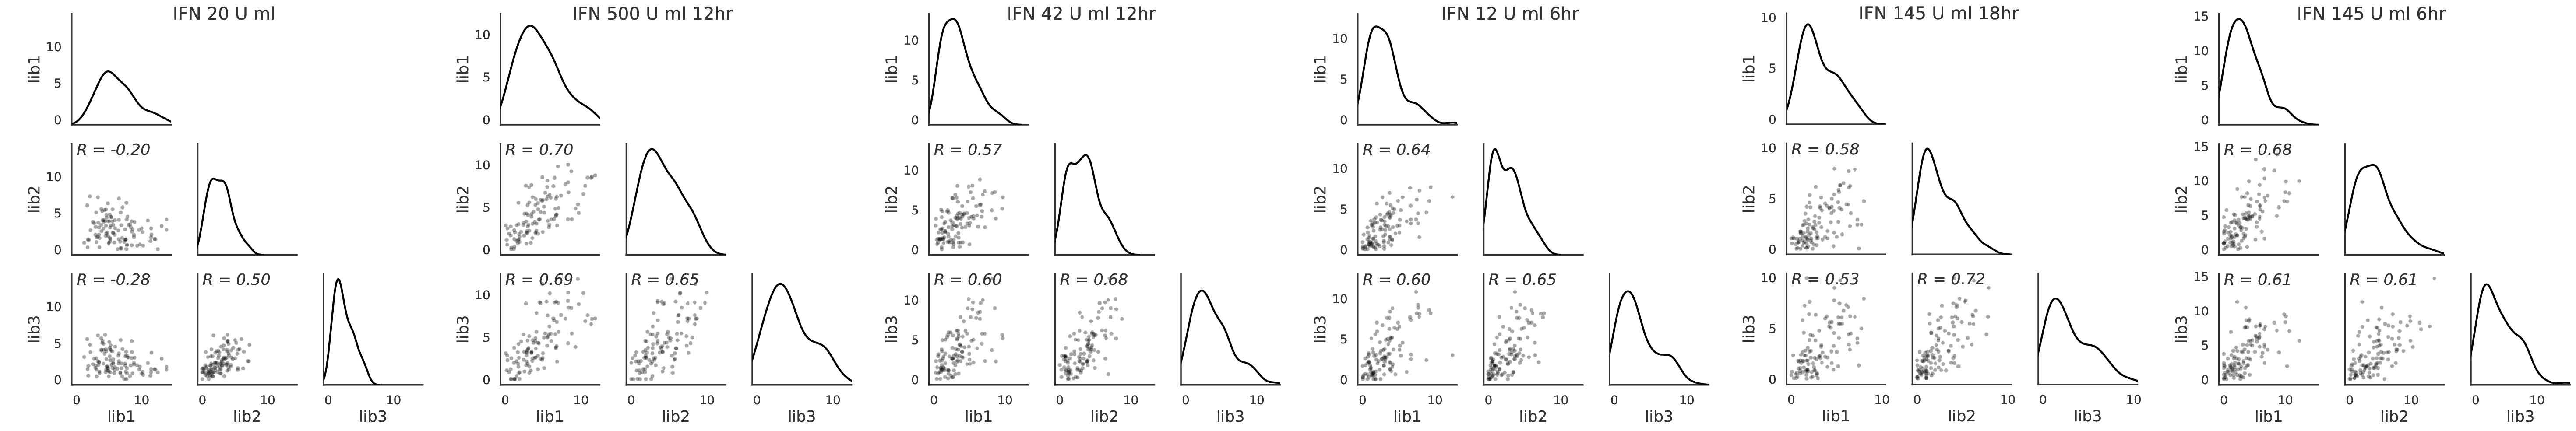



Correlations of absolute site selection among replicates:


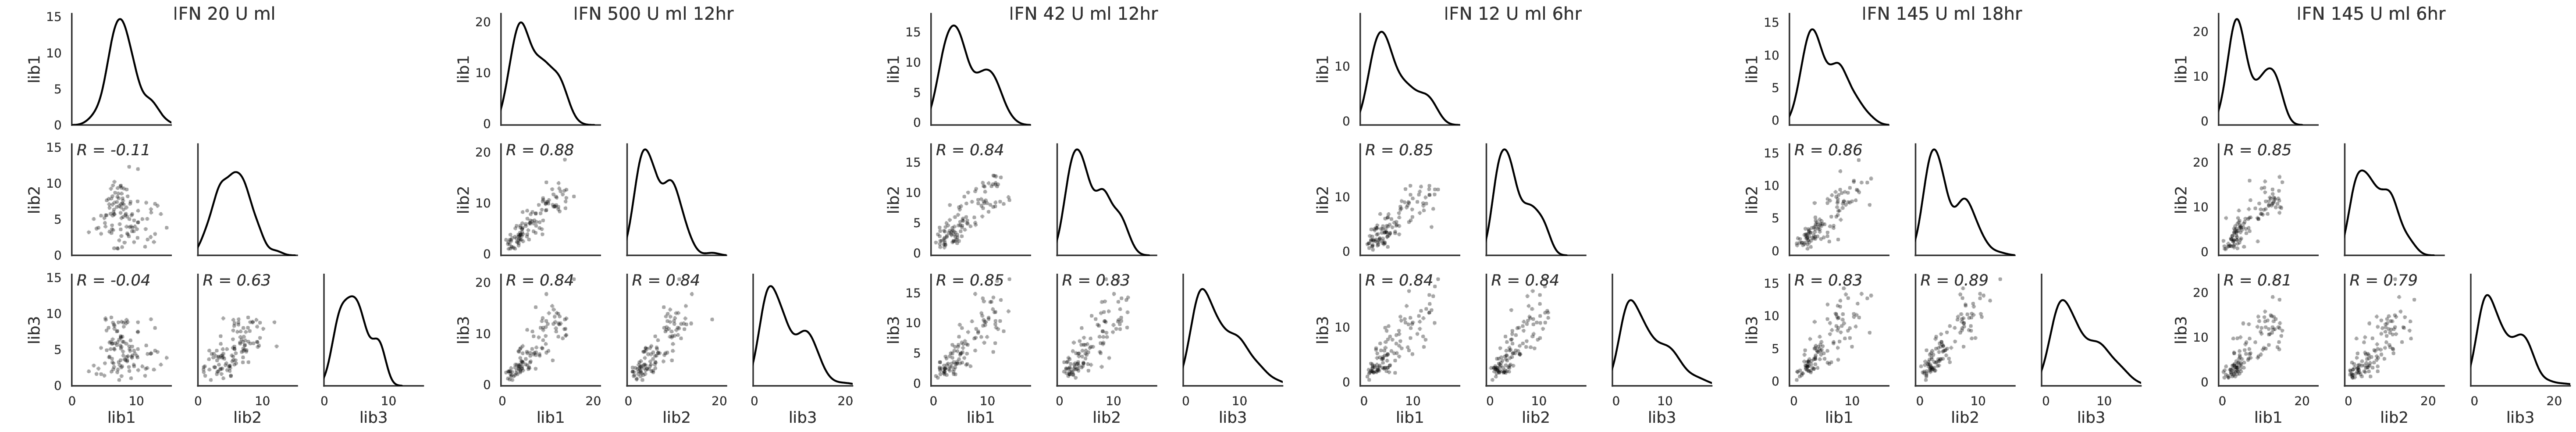



Correlations of mutation-level selection among replicates:


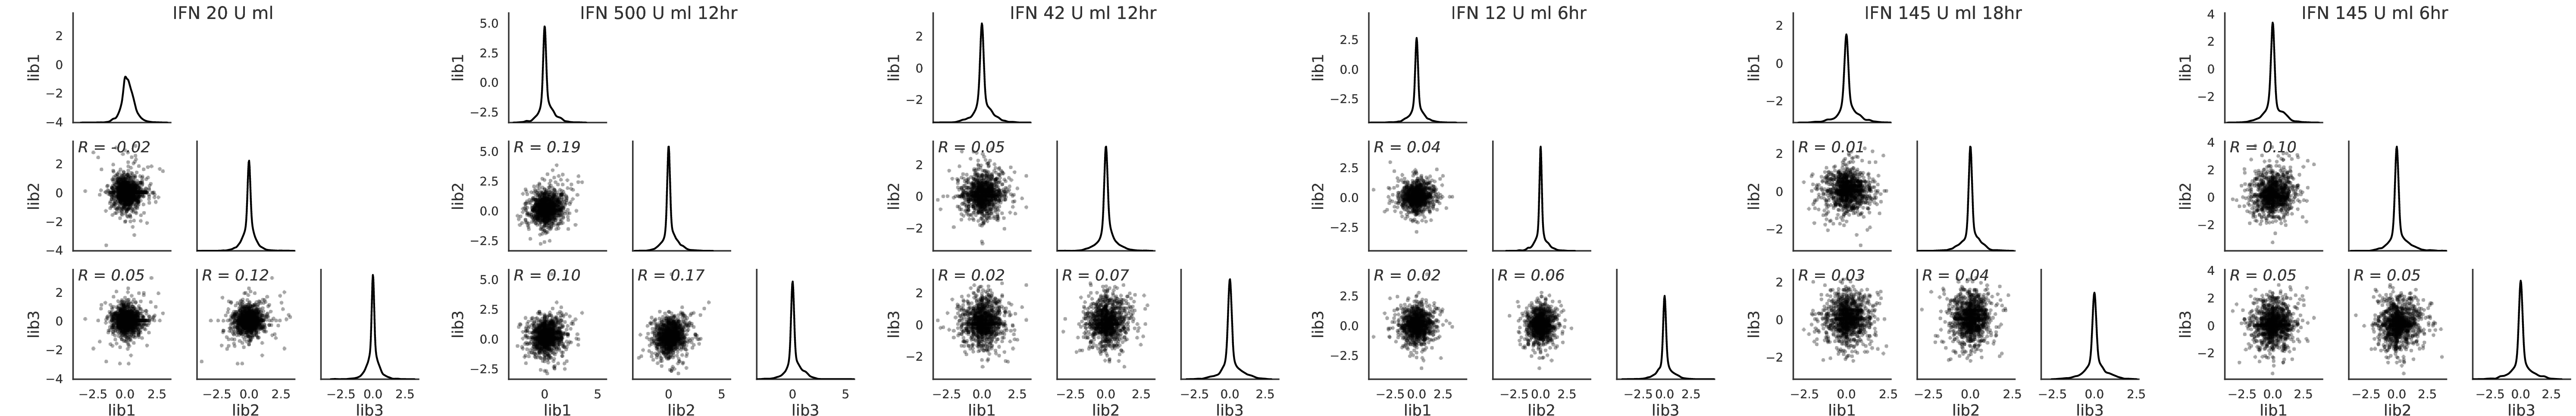

In [28]:
diffsel_groups = diffsel_batch['group'].unique().tolist()

for plot_type, desc in [('positivesite', 'positive site'),
                        ('absolutesite', 'absolute site'),
                        ('mut', 'mutation-level')]:
    print(f"\n\nCorrelations of {desc} selection among replicates:")
    showPDF([os.path.join(diffseldir, f"summary_{group}-{plot_type}diffselcorr.pdf")
             for group in diffsel_groups], width=350 * len(diffsel_groups))

Now make logo plots showing differential selection for each mutation.
Letters above the line indicate mutations differentially selected (favored)in the +IFN condition, and letters below the line indicates mutations differentially selected in the -IFN condition.
We plot the **medians** of the replicates:



Plotting differential selection for IFN-20-U-ml in ./results/diffsel/summary_IFN-20-U-ml-medianmutdiffsel.csv


Differential selection for IFN-20-U-ml:


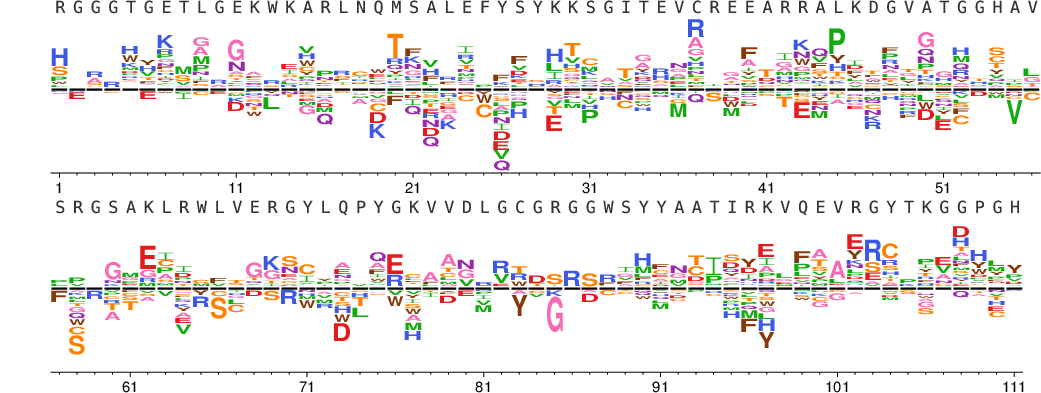



Plotting differential selection for IFN-500-U-ml-12hr in ./results/diffsel/summary_IFN-500-U-ml-12hr-medianmutdiffsel.csv


Differential selection for IFN-500-U-ml-12hr:


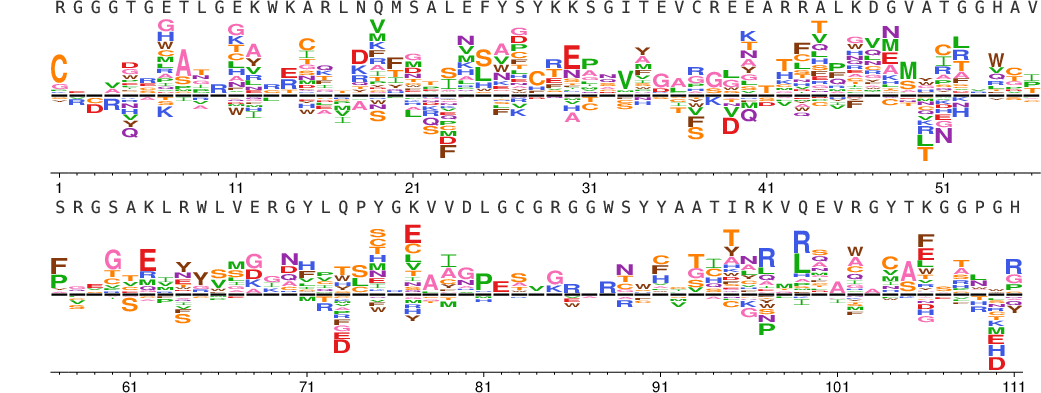



Plotting differential selection for IFN-42-U-ml-12hr in ./results/diffsel/summary_IFN-42-U-ml-12hr-medianmutdiffsel.csv


Differential selection for IFN-42-U-ml-12hr:


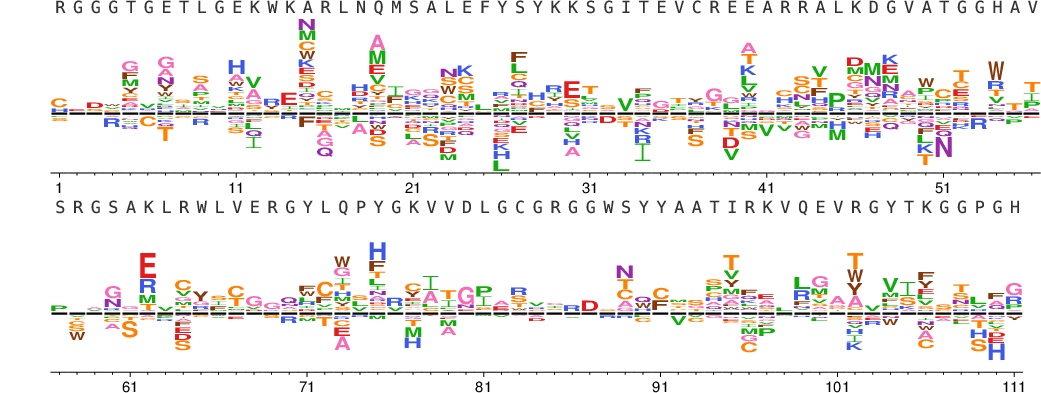



Plotting differential selection for IFN-12-U-ml-6hr in ./results/diffsel/summary_IFN-12-U-ml-6hr-medianmutdiffsel.csv


Differential selection for IFN-12-U-ml-6hr:


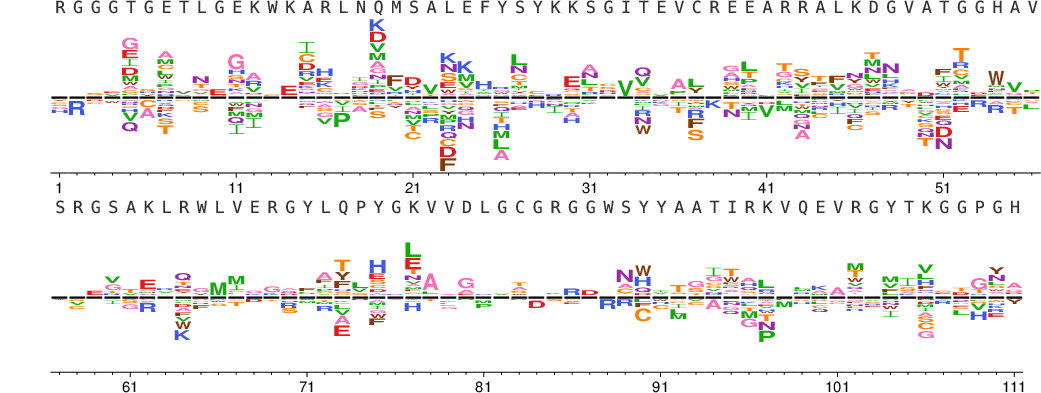



Plotting differential selection for IFN-145-U-ml-18hr in ./results/diffsel/summary_IFN-145-U-ml-18hr-medianmutdiffsel.csv


Differential selection for IFN-145-U-ml-18hr:


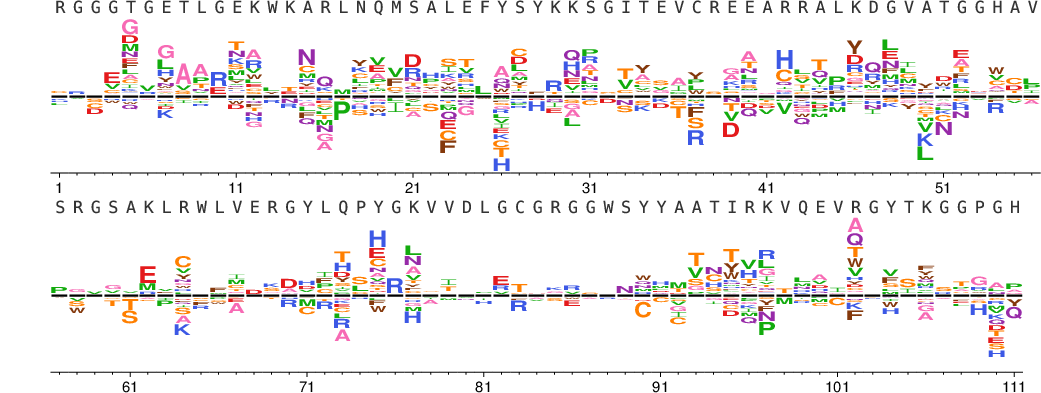



Plotting differential selection for IFN-145-U-ml-6hr in ./results/diffsel/summary_IFN-145-U-ml-6hr-medianmutdiffsel.csv


Differential selection for IFN-145-U-ml-6hr:


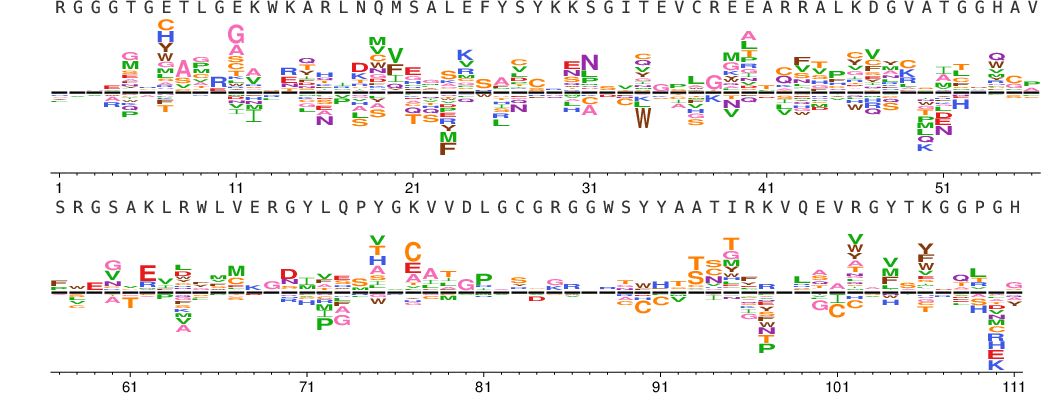

In [29]:
for group in diffsel_groups:
    
    diffsel_csv = os.path.join(diffseldir, f"summary_{group}-medianmutdiffsel.csv")
    print(f"\n\nPlotting differential selection for {group} in {diffsel_csv}")

    logoplot = os.path.join(logodir, f"{group}_diffsel.pdf")

    log = ! dms2_logoplot \
            --diffsel {diffsel_csv} \
            --name {group} \
            --outdir {logodir} \
            --nperline 56 \
            --overlay1 {wtoverlayfile} wildtype wildtype \
            --use_existing {use_existing}

    assert os.path.isfile(logoplot), '\n'.join(log)

    print(f"\n\nDifferential selection for {group}:")
    showPDF(logoplot)

## Create `dms-view` input files
Now we create a file to visualize the results of the deep mutational scanning using [dms-view], setting up the mapping for the [6WCZ](https://www.rcsb.org/structure/6wcz) PDB file.
In this PDB file, chain A is human STAT2 and chain B is ZIKV NS5.
The number is shifted such that sequential numbering of the sequence used in the deep mutational scanning is one greater than PDB numbering.
In other words, residue 6 in the PDB is residue 7 in the sequence used for the DMS.

In [30]:
offset_to_pdb = -1
pdb_chain = 'B'

In [31]:
dms_view_data = pd.DataFrame()

# preferences for all conditions
for condition, csvfile in prefs_files.items():
    prefs = pd.read_csv(csvfile)
    dms_view_data = dms_view_data.append(
        prefs
        .melt(id_vars='site',
              var_name='mutation',
              value_name='mut_preference',
              )
        .merge(dms_tools2.prefs.prefsEntropy(prefs, prefs.columns[1:].tolist())
               [['site', 'entropy', 'neffective']],
               on='site', validate='many_to_one')
        .assign(condition=condition)
        )
    
# diffsel for IFN+ versus IFN-
dms_view_data = (
    dms_view_data
    .merge(pd.read_csv(diffsel_csv).fillna(0),
           on=['site', 'mutation'], validate='many_to_one')
    .rename(columns={'mutdiffsel': 'mut_diffsel',
                     'entropy': 'site_entropy',
                     'neffective': 'site_neffective'})
    .assign(site_max_diffsel=lambda x: x.groupby('site')['mut_diffsel'].transform('max'),
            site_positive_diffsel=lambda x: x.groupby('site')['mut_diffsel'].transform(lambda s: s.clip(lower=0).sum())
            )
    )

# add PDB information
dms_view_data = dms_view_data.assign(label_site=lambda x: x['site'] + offset_to_pdb,
                                     protein_site=lambda x: x['label_site'],
                                     protein_chain=pdb_chain)

# display and print
dms_view_dir = './results/dms_view/'
os.makedirs(dms_view_dir, exist_ok=True)
dms_view_csv = os.path.join(dms_view_dir, 'data.csv')
print(f"Writing CSV to {dms_view_csv}; here are first few lines:")
dms_view_data.to_csv(dms_view_csv)
display(HTML(dms_view_data.head().to_html()))

Writing CSV to ./results/dms_view/data.csv; here are first few lines:
